![](assets/header-logo.png)
## *Semantic Image Segmentation*

**Automated and Connected Driving Challenges - Research Project - 09/2024**

**Research Topic 1: Domain Adaptation for Semantic Image Segmentation**


| Author | Mail | Matriculation
| --- | --- | ---
| **Gaurav Gidnahalli Anil Reddy** | gaurav.gidnahalli.anil.reddy@rwth-aachen.de / gauravgreddy@gmail.com| 442090
| **Sidhant Konwar Roy** | sidhant.roy@rwth-aachen.de / sidhantkr9@gmail.com | 441084



In [1]:
# === INSTALLATION OF PYTHON DEPENDENCIES ==========================

!pip3 install -r Requirements.txt
import sys

# --- installation via pip -----------------------------------------

# # install packages via pip (version numbers should be included to guarantee reproducibility)
# !{sys.executable} -m pip install \
#     jupyter \
#     tensorflow\
#     matplotlib\
#     numpy \
#     opencv-python \
#     tqdm

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dropout, Activation, Concatenate, RandomRotation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint 

from segmentation_utils.metrics import SparseMeanIoU
from mpl_toolkits.axes_grid1 import ImageGrid

import glob, sys, os, time
import numpy as npy
import random
import matplotlib.pyplot as plot
import cv2
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

random.seed(random.randint(0, 150))

%matplotlib inline
plot.rcParams['figure.figsize'] = (15, 15)

c:\Users\GAURAV\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The following are user-defined functions for downloading and extracting zip files from Google Drive to make it easier for the reader to access the data.

In [ ]:
# Taken from ChatGPT
import gdown
import zipfile, os

def download_file_from_google_drive(file_id, save_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, save_path, quiet=False)
    print(f"File downloaded successfully and saved to {save_path}")

def unzip_file(zip_file_path, extract_to_folder):
    # Create the folder if it doesn't exist
    if not os.path.exists(extract_to_folder):
        os.makedirs(extract_to_folder)

    # Unzip the file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_folder)
            print(f"Files extracted successfully to {extract_to_folder}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file or it is corrupted.")

In [ ]:
# Taken from ChatGPT

file_id = '1Z_yZWpYdrnc0n6hefwD__9plos7H5fTs' # https://drive.google.com/file/d/1Z_yZWpYdrnc0n6hefwD__9plos7H5fTs/view?usp=drive_link
save_folder = os.getcwd()
save_path = os.path.join(save_folder, 'segmentation_utils.zip') 
extract_to_folder = os.path.join(save_folder, '')

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if not os.path.exists(save_path):
    # Download the file
    download_file_from_google_drive(file_id, save_path)

    # Unzip the downloaded file
    unzip_file(save_path, extract_to_folder)

else:
    print("File already exists. Skipping download.")



##### Downloads

We have chosen the [KITTI](https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip) [[1]](https://www.cvlibs.net/publications/Alhaija2018IJCV.pdf) and CityScapes ([Image](https://www.cityscapes-dataset.com/file-handling/?packageID=3) and [Label](https://www.cityscapes-dataset.com/file-handling/?packageID=1)) [[2]](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes.pdf) datasets for the following research. A dataset from IKA is also used for evaluation. 

To manually download the datasets download and unzip the contents in a new folder 'datasets' located in the same folder as this jupyter notebook. To automate this process, please run the following cells.

In [ ]:
!mkdir datasets

#KITTI

file_id = '1noeCGWhE0S_3V4b-N9fCW89ppK1cgDnG' # https://drive.google.com/file/d/1noeCGWhE0S_3V4b-N9fCW89ppK1cgDnG/view?usp=sharing
save_folder = os.getcwd()+'/datasets'
save_path = os.path.join(save_folder, 'data_semantics.zip')
extract_to_folder = os.path.join(save_folder, 'KITTI_Dataset')

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if not os.path.exists(save_path):
    # Download the file
    download_file_from_google_drive(file_id, save_path)

    # Unzip the downloaded file
    unzip_file(save_path, extract_to_folder)

else:
    print("File already exists. Skipping download.")

In [ ]:
#CityScapes Labels

file_id = '1WErVByw6CxhFxYHdmQv3qphPHTFXeB-X' # https://drive.google.com/file/d/1WErVByw6CxhFxYHdmQv3qphPHTFXeB-X/view?usp=drive_link
save_folder = os.getcwd()+'/datasets'
save_path = os.path.join(save_folder, 'gtFine_trainvaltest.zip')
extract_to_folder = os.path.join(save_folder, 'gtFine_trainvaltest')

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if not os.path.exists(save_path):
    # Download the file
    download_file_from_google_drive(file_id, save_path)

    # Unzip the downloaded file
    unzip_file(save_path, extract_to_folder)

else:
    print("File already exists. Skipping download.")

In [ ]:
# CityScapes Images

file_id = '1sQuChAIdEcSQ78J3lCEcHgu5qvvdZicJ' # https://drive.google.com/file/d/1sQuChAIdEcSQ78J3lCEcHgu5qvvdZicJ/view?usp=sharing
save_folder = os.getcwd()+'/datasets'
save_path = os.path.join(save_folder, 'leftImg8bit_trainvaltest.zip')
extract_to_folder = os.path.join(save_folder, 'leftImg8bit_trainvaltest')

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if not os.path.exists(save_path):
    # Download the file
    download_file_from_google_drive(file_id, save_path)

    # Unzip the downloaded file
    unzip_file(save_path, extract_to_folder)

else:
    print("File already exists. Skipping download.")

In [ ]:
#IKA Test Dataset

file_id = '12vuR2iRM42L4Y34jB-Dl5IwZDRf3-qLv' #https://drive.google.com/file/d/12vuR2iRM42L4Y34jB-Dl5IwZDRf3-qLv/view?usp=drive_link
save_folder = os.getcwd()+'/datasets'
save_path = os.path.join(save_folder, 'ika-dataset.zip')
extract_to_folder = os.path.join(save_folder, '')

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if not os.path.exists(save_path):
    # Download the file
    download_file_from_google_drive(file_id, save_path)

    # Unzip the downloaded file
    unzip_file(save_path, extract_to_folder)

else:
    print("File already exists. Skipping download.")

#### **Abstract**

**Semantic image segmentation is an important task in computer vision, particularly for applications such as autonomous driving and medical imaging. Its performance is mainly limited by the availability of labelled standardised datasets. In addition, models trained on one dataset often exhibit poor performance when applied to data from different domains due to domain shift. Domain adaptation can be used to address this issue by improving model generalization across various domains. The following report investigates the effectiveness of augmentation and hyperparameter optimization techniques in domain adaptation for semantic image segmentation.**

### **Introduction**

Semantic image segmentation is simply the task of assigning a class label to every single pixel of an input image ([Fig.1](https://cdn.prod.website-files.com/614c82ed388d53640613982e/63f4aabd9537d009915e9d44_computer%20vision%20based%20self%20driving%20cars.gif)). As simple as it may seem it is crucial for understanding and interpreting visual information in various applications such as autonomous driving, medical imaging, and robotics. [[3]](https://arxiv.org/abs/1411.4038)[[4]](https://arxiv.org/abs/1706.05587) Accurate segmentation is of the utmost importance for the effectiveness and safety in these applications. For example, in autonomous driving, the ability to accurately segment different objects in the environment, such as vehicles, pedestrians, and road signs, is critical for navigation and decision-making.

Recent advances in deep learning allow for a significant performance boost in many computer vision tasks, including semantic image segmentation. However, the success of deep learning methods typically depends on the availability of large amounts of annotated training data. Manual annotation of images with pixel-wise semantic labels is an extremely tedious and time consuming process. [[5]](https://arxiv.org/abs/1505.04597)[[6]](https://ar5iv.labs.arxiv.org/html/2112.03241) Initially taking an hour or more per image, recent semi-automatic tools manage to reduce the annotation time for common urban classes (people, road surface or vehicles), however they still require manual verification and validation.

By leveraging augmentation and hyperparameter optimization techniques, our work provides a practical and effective approach to domain adaptation for semantic image segmentation, addressing the critical challenge of domain shift and enhancing model performance across diverse datasets. [[7]](https://arxiv.org/abs/1707.09465)

<br>

<img src="https://cdn.prod.website-files.com/614c82ed388d53640613982e/63f4aabd9537d009915e9d44_computer%20vision%20based%20self%20driving%20cars.gif" width="700">

[Fig.1: Example of semantic image segmentation taken from CityScapes Dataset](https://cdn.prod.website-files.com/614c82ed388d53640613982e/63f4aabd9537d009915e9d44_computer%20vision%20based%20self%20driving%20cars.gif)

Below, the report is structured into the following sections:<br>
**Related Work**: Concepts defined and elaborated based on related literature.<br>
**Methodology**: Introduction to the methodologies used to investigate the required aspects.<br>**Experiments**: Execution of the respective methods.<br>
**Evaluation**: Categorizing, analyzing and comparing the obtained results.<br>
**Conclusion**: A concise overview of the results and further research possibilities.

### **Related Work**

This section introduces the reader to the basic terminology required for the following research. It comprises of references to related research work. The concepts of semantic image segmentation, the corresponding datasets and domain adaptation are enlightened upon.

#### Semantic Image Segmentation

In the most general terms, image segmentation is the process of partitioning an image into several regions. The pixels of these regions generally should share certain characteristics. in general, there are three groups of image segmentation tasks: Semantic segmentation, Instance segmentation and Panoptic segmentation. The defining feature of semantic segmentation that differentiates it from instance segmentation is that it does not distinguish between different objects that belong to the same class. [[8]](https://link.springer.com/article/10.1007/s13735-017-0141-z)[[9]](https://arxiv.org/abs/1801.00868)

Recent research has focused on advancing segmentation models, usage of large-scale annotated datasets like KITTI and Cityscapes, and addressing domain shift through domain adaptation techniques. The model introduced by Long et al. [[3]](https://arxiv.org/abs/1411.4038) is the first deep network for semantic image segmentation which uses fully convolutional layers to process images of arbitrary size and to produce a segmentation map of the same. ParseNet overcomes some of the limitations of FCNs, by complementing these models with a global context. [[10]](https://arxiv.org/abs/1506.04579) Encoder-decoder based models are trained by minimizing a reconstruction loss between the ground truth and the predicted segmentation map. Subsequent architectures like U-Net (Ronneberger et al., 2015) [[5]](https://arxiv.org/abs/1505.04597) further improved segmentation performance, particularly in biomedical imaging, by introducing symmetric encoder-decoder structures with skip connections that combine high-level features with low-level details. The original U-Net has been modified into versions like 3D U-Net (Çiçek et al., 2016) [[11]](https://arxiv.org/abs/1606.06650) for volumetric data and Attention U-Net (Oktay et al., 2018) [[12]](https://arxiv.org/abs/1804.03999) that incorporates attention mechanisms to focus on relevant features. 

#### Datasets

Benchmark datasets have significantly contributed to advancing semantic segmentation research. They are usually at the pixel-level or instance-level. Recent datasets offer diverse scene categories and pixel-level annotations, enabling more comprehensive evaluations of segmentation algorithms. [[13]](https://arxiv.org/abs/1612.03716)

#### Domain Adaptation

The main domain adaptation goal is ensuring that semantic image segmentation models perform well on real target data, by leveraging annotated, synthetic and non-annotated real data. A classical domain adaptation framework relies on either SYNTHIA [[14]](https://ieeexplore.ieee.org/document/7780721) or GTA [[15]](https://arxiv.org/abs/1608.02192) datasets as a source, and the real-world dataset, like Cityscapes, as a target. Early domain adaptation methods were directly inspired by adaptation methods invented for image classification. However semantic image segmentation is a more complex task, as labeling is done on the pixel level.  To address this , most domain adaptation semantic image segmentation methods take into account the spatial structure and the local image context, act at multiple levels of the segmentation pipeline and often combine multiple techniques. [[16]](https://arxiv.org/abs/1612.02649)

Adversarial training, domain-specific normalization layers, and unsupervised domain adaptation methods have shown promising results in adapting segmentation models to unseen domains. [[17]](https://arxiv.org/abs/1802.10349) Techniques such as domain randomization, multi-modal fusion, and meta-learning have been explored to enhance model robustness and adaptability. [[18]](https://arxiv.org/abs/1703.06907) [[19]](https://arxiv.org/pdf/2009.12829) U-Net based models have been adapted to ensure effective transfer learning across domains. Techniques such as CycleGAN (Zhu et al., 2017) [[20]](https://arxiv.org/abs/1703.10593) for image-to-image translation have been employed to generate target-like images from source domain data, enabling better generalization. Additionally, domain adversarial training and self-ensembling approaches (French et al., 2018) [[21]](https://arxiv.org/abs/1706.05208) have been integrated with U-Net to enhance its adaptability. Domain adaptation methods continue to play a crucial role in improving model generalization and robustness across different domains, contributing to the advancement of semantic segmentation research.

<br>

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="700">

[Fig.2: U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

As seen in [Fig.2](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png), each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations. [[5]](https://arxiv.org/abs/1505.04597)

### **Methodology**

A few approaches were mentioned to consider and investigate the domain adaptation of semantic image segmentation.  In this section, the chosen datasets are processed and elaborated, some data augmentation techniques are visited and finally the structure and the tuning of the model itsef is examined.

### Datasets

Recent research has focused on advancing segmentation models, leveraging large-scale annotated datasets like KITTI and Cityscapes, and addressing domain shift through domain adaptation techniques. The KITTI dataset provides high-resolution images captured from vehicle-mounted sensors, along with pixel-level annotations for object detection, tracking, and segmentation tasks. [[1]](https://www.cvlibs.net/publications/Alhaija2018IJCV.pdf) Cityscapes, on the other hand, offers urban street scenes with fine-grained pixel-level annotations, making it suitable for semantic segmentation research. [[2]](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes.pdf)

The KITTI semantic segmentation benchmark consists of 200 semantically annotated train as well as 200 test images, recorded in Germany. [[1]](https://www.cvlibs.net/publications/Alhaija2018IJCV.pdf) The CityScapes dataset was recorded in 50 German cities and offers high quality pixel-level annotations of 5000 frames (training and validation sets containing 3475 annotated images and test set containing 1525 images) with the following diversity:<br> 
Several months (spring, summer, fall),<br>
Daytime,<br>
Good/medium weather conditions, and<br>
Manually selected frames. [[2]](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes.pdf)



### Import KITTI Dataset

The image and label pairs are read from the downloaded and extracted dataset files. The list of image-label pairs is randomly shuffled to ensure a good mix of data. A ratio of 70:30 is used to split the training dataset for training and validation. 

In [6]:
# Set the ratio of the dataset to be used for training.
# 70% of the data will be used for training and the remaining 30% for validation.
Training_Validation_split = 0.7

# Define the paths to the directories containing the training images and labels.
# These paths should be updated according to the actual locations of your dataset.
KITTI_image_path_train = os.getcwd()+"/datasets/KITTI_Dataset/training/image_2"
KITTI_label_path_train = os.getcwd()+"/datasets/KITTI_Dataset/training/semantic_rgb"

# Initialize an empty list to hold pairs of image and label file paths.
# Each pair will be a tuple (image_path, label_path).
KITTI_image_label_pairs = [] #pair = [('image_path1.png', 'label_path1.png'),('image_path2.png', 'label_path2.png')]  tuple list

# List all files in the image directory.
images = os.listdir(KITTI_image_path_train)
for image_file in images:
    # Check if the file is a PNG image.
    if image_file.endswith('.png'):
        # Construct the full path to the image file.
        image_path = os.path.join(KITTI_image_path_train, image_file)
        # Construct the corresponding label file path.
        label_path = os.path.join(KITTI_label_path_train, image_file)

        # Check if the label file exists.  
        if os.path.exists(label_path):
           # If it exists, add the pair (image_path, label_path) to the list.
            KITTI_image_label_pairs.append((image_path, label_path))

# Randomly shuffle the list of image-label pairs to ensure a good mix of data.
random.shuffle(KITTI_image_label_pairs)

# Calculate the index at which to split the dataset into training and validation sets.
split_index = int(Training_Validation_split * len(KITTI_image_label_pairs))

# Split the dataset: 
# - The first part (up to split_index) is for training.
# - The second part (from split_index to the end) is for validation.
KITTI_training_image_label_pairs = KITTI_image_label_pairs[:split_index]
KITTI_validation_image_label_pairs = KITTI_image_label_pairs[split_index:]

# Read the first image from the training set to get its dimensions.
# This will give us the height, width, and number of channels of the images in the dataset.
KITTI_image_Height, KITTI_image_width, KITTI_num_channels = plot.imread(KITTI_training_image_label_pairs[0][0]).shape #Collects the shape of image

#### Import CityScapes Dataset

The image and label pairs are read from the downloaded and extracted dataset files respectively. This dataset already has seperate training, validation and testing image-label pairs. Since the images and labels are contained in different city folders, a function is used to iterate through all cities in the image and label directories and listing the corresponding files. The list of image-label pairs is randomly shuffled to ensure a good mix of data.

The function in the cell below generates pairs of image and label file paths from the CityScapes dataset, iterating through all cities in the image_dir, and for each city, listing the image files. It checks for files ending with the respective suffix of the image files, and constructs the corresponding label file name by replacing the suffixes with that of the label files. If the label file exists in the label directory, it adds a tuple of the image and label file paths to the list of pairs. In the end a list of image-label pairs is generated.

In [8]:
def load_cityscapes_pairs(image_dir, label_dir):
   
    CityScape_image_label_pairs = [] #pair = [('image_path1.png', 'label_path1.png'),('image_path2.png', 'label_path2.png')]
    cities = os.listdir(image_dir)
   
    for city in cities:
        image_city_dir = os.path.join(image_dir, city)
        label_city_dir = os.path.join(label_dir, city)
        
        images = os.listdir(image_city_dir)
       
        for image_file in images:
            if image_file.endswith('_leftImg8bit.png'):
                image_path = os.path.join(image_city_dir, image_file)
                label_file = image_file.replace('_leftImg8bit.png', '_gtFine_color.png')
                label_path = os.path.join(label_city_dir, label_file)
               
                if os.path.exists(label_path):
                    CityScape_image_label_pairs.append((image_path, label_path))
   
    return CityScape_image_label_pairs

In [9]:
#Training Dataset
# Directories
image_dir = os.getcwd()+"/datasets/leftImg8bit_trainvaltest/leftImg8bit/train"
label_dir = os.getcwd()+"/datasets/gtFine_trainvaltest/gtFine/train"

# Load pairs
CityScape_training_image_label_pairs = load_cityscapes_pairs(image_dir, label_dir)

#Shuffle the dataset
random.shuffle(CityScape_training_image_label_pairs)

CityScape_image_Height, CityScape_image_width, CityScape_num_channels = plot.imread(CityScape_training_image_label_pairs[0][0]).shape #Collects the shape of image



#Validation Dataset
# Directories
image_dir = os.getcwd()+"/datasets/leftImg8bit_trainvaltest/leftImg8bit/val"
label_dir = os.getcwd()+"/datasets/gtFine_trainvaltest/gtFine/val"

# Load pairs
CityScape_validation_image_label_pairs = load_cityscapes_pairs(image_dir, label_dir)

#Shuffle the dataset
random.shuffle(CityScape_validation_image_label_pairs)

A smaller subset is created from the larger CityScapes dataset from the Cologne data (154 image-label pairs) as the training dataset and the Lindau data (59 image-label pairs) as the validation dataset. This allows for cross-validation with similar-sized KITTI dataset and speeds up the runtime for training the models so as to achieve results with more hyperparameter values.

In [25]:
#Create CityScape subset dataset

CityScape_subset_training_image_label_pairs = []

for train_pair in CityScape_training_image_label_pairs:
    if 'cologne' in train_pair[0]:
        CityScape_subset_training_image_label_pairs.append(train_pair)


CityScape_subset_validation_image_label_pairs = []

for val_pair in CityScape_validation_image_label_pairs:
    if 'lindau' in val_pair[0]:
        CityScape_subset_validation_image_label_pairs.append(val_pair)

Finally, the KITTI and CityScape image-label pairs are merged. This dataset contains the most image-label pairs, but would require a significant amount of training time compared to the previously created datasets.

In [24]:
#Training dataset

merged_training_image_label_pairs = KITTI_training_image_label_pairs.copy()
merged_training_image_label_pairs.extend(CityScape_training_image_label_pairs)

#Shuffle the dataset
random.shuffle(merged_training_image_label_pairs)


#Validation dataset

merged_validation_image_label_pairs = KITTI_validation_image_label_pairs.copy()
merged_validation_image_label_pairs.extend(CityScape_validation_image_label_pairs)

#Shuffle the dataset
random.shuffle(merged_validation_image_label_pairs) 

For evaluating the trained models the ika dataset comprising of 28 image-label pairs is used, which is comprised of images taken from the city of Aachen. This provides a base to compare the obtained results from all the iterations.

In [23]:
ika_dataset_image_path_train = os.getcwd()+"/datasets/ika-dataset/input"
ika_dataset_label_path_train = os.getcwd()+"/datasets/ika-dataset/label"

# Initialize an empty list to hold pairs of image and label file paths.
# Each pair will be a tuple (image_path, label_path).
ika_test_image_label_pairs = [] #pair = [('image_path1.png', 'label_path1.png'),('image_path2.png', 'label_path2.png')]  tuple list

# List all files in the image directory.
images = os.listdir(ika_dataset_image_path_train)
for image_file in images:
    # Check if the file is a PNG image.
    if image_file.endswith('.png'):
        # Construct the full path to the image file.
        image_path = os.path.join(ika_dataset_image_path_train, image_file)
        # Construct the corresponding label file path.
        label_path = os.path.join(ika_dataset_label_path_train, image_file[0:-4] + "_gtFine_labelColor.png")

        # Check if the label file exists.  
        if os.path.exists(label_path):
           # If it exists, add the pair (image_path, label_path) to the list.
            ika_test_image_label_pairs.append((image_path, label_path))

# Randomly shuffle the list of image-label pairs to ensure a good mix of data.
random.shuffle(ika_test_image_label_pairs)

Each class is associated with a certain color. The association between the color and the classes is stored in the dictionary in the given script path. It contains the mapping from the RGB color code to the class ID where each class corresponds to a semantic class such as Road, Sidewalk or Person. Since the test dataset has 12 colour association IDs, the input datasets are given the same association.
Please find the detailed colour association with the respective class below.

In [22]:
# Define the path to the script containing the color association dictionary
script_path = os.getcwd()+'/datasets/ika-dataset'

# Add the script's directory to the system path
sys.path.append(script_path)

# Import the script file
import rgb_to_class_id

# Copy the dictionary contents into a new dictionary
RGB_to_ClassID = rgb_to_class_id.rgb_to_class_id  # newDict = fileName.oldDict

# To count the number of classes
count = 0
value_i = -1
for key, value in RGB_to_ClassID.items():
    if value_i == value:
        continue
    else:
        count += 1
        value_i = value

num_classes = count #Stores the number of classes in dictionary

In [ ]:
#RGB Colour Code to Class ID

# rgb_to_class_id = {

#     (128, 64, 128):  0,   # Road

#     (244, 35, 232):  1,   # Sidewalk

#     ( 70,  70,  70): 2,   # Building
#     (102, 102, 156): 2,   # Wall
#     (150, 100, 100): 2,   # Bridge
#     ( 50, 120,  90): 2,   # Tunnel
#     (190, 153, 153): 2,   # Fence
#     (180, 165, 180): 2,   # Guard rail

#     (153, 153, 153): 3,   # Pole
#     (250, 170,  30): 3,   # Traffic light
#     (220, 220,   0): 3,   # Traffic sign

#     (107, 142,  35): 4,   # Vegetation
#     (152, 251, 152): 4,   # Terrain

#     ( 70, 130, 180): 5,   # Sky

#     (220,  20,  60): 6,   # Person

#     (255,   0,   0): 7,   # Rider
#     (  0,   0, 230): 7,   # Motorcycle
#     (119,  11,  32): 7,   # Bicycle

#     (  0,   0, 142): 8,   # Car
#     (  0,   0, 110): 8,   # Trailer

#     (  0,   0,  70): 9,   # Truck

#     (  0,  60, 100): 10,  # Bus
#     (  0,   0,  90): 10,  # Caravan

#     (  0,   0,   0): 11,  # None
#     ( 81,   0,  81): 11,  # Ground
#     (111,  74,   0): 11,  # Dynamic
#     (  0,  80, 100): 11,  # Train
#     (250, 170, 160): 11,  # Parking
#     (230, 150, 140): 11,  # Rail track
# }

Many functions in the following sections are taken from the [Automated and Connected Driving Challenges](https://learning.edx.org/course/course-v1:RWTHx+ACDC+3T2023/home) course on edX. The first function converts an image with RGB class encoding into a segmentation map where each pixel is assigned a class ID based on its RGB value. For each RGB tuple and corresponding class ID , the segmentation_map tensor is updated. If a pixel is matched with the current color, the segmentation_map is updated with the class_id. Otherwise, the value remains unchanged. The final tensor is then changed from [height, width] to [height, width, 1] to make it compatible with neural network processing. The second function converts the segmentation maps to RGB images which enables the visualization of segmentation results.


In [21]:
#Code taken from ACDC Course

def convert_rgb_encoding_to_segmentation_map(image, RGB_to_ClassID):
    
    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    for color, class_id in RGB_to_ClassID.items():            
        segmentation_map = tf.where(
                                    condition=tf.reduce_all((tf.equal(image, color)), axis = -1),
                                    x=tf.cast(class_id, tf.uint8),
                                    y=segmentation_map
                                    )
        
    # Add dimension to change the shape from [height, width] to [height, width, 1]
    segmentation_map = tf.expand_dims(segmentation_map, axis = -1)
        
    return segmentation_map


def segmentation_map_to_rgb_encoding(segmentation_map, RGB_to_ClassID):
    
    rgb_encoding = npy.zeros([segmentation_map.shape[0], segmentation_map.shape[1], 3], dtype=npy.uint8)
    
    for color, class_id in RGB_to_ClassID.items():       
        
        rgb_encoding[tf.squeeze(segmentation_map)==class_id] = color  
    
    return rgb_encoding

The first function processes the image-label pairs from the dataset. The image and label files are decoded and resized to the same size. Then the parsed label files are converted to segmentation maps using the previous function. The second function is used to normalize the range of RGB values of the image files from [0,255] to [0,1].

In [16]:
#Code taken from ACDC Course

def parse_sample(image_path, label_path):
        
    image_rgb = tf.image.decode_png(tf.io.read_file(image_path), channels = 3)
    label_rgb = tf.image.decode_png(tf.io.read_file(label_path), channels = 3)
    
    
    # Resize all images and labels to a uniform size, because some images in the dataset have different sizes
    image_rgb = tf.image.resize(image_rgb, [368, 1248], method=tf.image.ResizeMethod.BILINEAR)
    label_rgb = tf.image.resize(label_rgb, [368, 1248], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image_rgb = tf.cast(image_rgb, tf.uint8) 
    
    # apply convert_rgb_encoding_to_segmentation_map to the label_rgb image
    label_segmentation_map = convert_rgb_encoding_to_segmentation_map(label_rgb, RGB_to_ClassID)
    
    
    return image_rgb, label_segmentation_map


def normalize(image, label):
    
    image = tf.cast(image, tf.float32) / 255.0  # image = None    
    return image, label

As stated before, labelled data for machine learning is very expensive to obtain. Augmentation techniques are used to artificially increase the size of the training dataset.
 
The first function is used to flip the image-label pair along the 1-dimension with a defined probability. The second function is used to augment the lighting effects of the image, namely gamma, brightness and contrast. This helps simulate different illumination conditions occurring over the course of the day. Gaussian noise is added to the input images in the third function to increase the robustness of the network. The labels remain unchanged for the second and third functions.

In [17]:
#Taken from ACDC Course with modifications
def horizontal_flip(image, label, flip_prob):

    if flip_prob < tf.random.uniform(shape=[], dtype=tf.float16):

        return image, label
    
    else:
        
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

        return image, label
    


def brightness_contrast_gamma(image, label, light_prob):
    
    if light_prob < tf.random.uniform(shape=[], dtype=tf.float16):

        return image, label
    
    else:
        random_gamma = tf.random.uniform(shape=[], minval=0.5, maxval=1.5, dtype=tf.float32)

        image = tf.image.adjust_gamma(image, gamma=random_gamma)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        
        return image, label
    


def random_noise_blur(image, label, noise_prob):
    
    if noise_prob < tf.random.uniform(shape=[], dtype=tf.float16):

        return image, label
    
    else: 

        # Create a random standart deviation - simulates the intensity of the noise
        random_stddev = tf.random.uniform(shape=[], minval=2, maxval=30, dtype=tf.float32)
        
        # Create a noise tensor with a shape like the input image. Use zero-mean and a random std
        noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=random_stddev, dtype=tf.float32)
        
        # Add the noise to the image. Cast the image to tf.float32 before the addition
        image = tf.cast(image, dtype=tf.float32) + noise
        
        # Clip the values of the image to [0, 255] 
        image = tf.clip_by_value(image, 0.0, 255.0) 
        
        # Cast the image back to tf.uint8
        image = tf.cast(image, dtype=tf.uint8)  
        
        return image, label

The following function applies random zoom augmentation to the image-label pair, cropping it by a random scale and then resizing to its original dimensions.

In [18]:
#Taken from ACDC Course
def random_zoom(image, label, zoom_prob):
    """
    Randomly applies random zoom augmentation to the image-label pair. Randomly resizes the image 
    and then crops it back to original size.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """

    if zoom_prob < tf.random.uniform(shape=[], dtype=tf.float16):

        return image, label
    
    else:

        # Store the original height, width of the input image
        original_shape = tf.shape(image)[:2]
        
        # Create a random scale between 1 und 2.5
        scale = tf.random.uniform(shape=[], minval=1, maxval=2.5, dtype=tf.float32)
        
        # Calculate the new dimension after scaling the the original image with scale
        new_dim = tf.cast(tf.cast([image.shape[0], image.shape[1]], tf.float32)*scale, tf.int32)
        
        # Resize the image to the new dimension  
        image = tf.image.resize(image, new_dim, method=tf.image.ResizeMethod.BILINEAR)
        label = tf.image.resize(label, new_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        # Resize returns tf.float32 for BILINEAR, convert back to tf.uint8
        image = tf.cast(image, tf.uint8)  
        
        # Calculate the positions boundaries of the top left corner of the new crop
        min_top_left = tf.constant([0, 0], dtype=tf.int32)
        max_top_left = new_dim - original_shape
        
        # Generate a random position of the new crop
        x_top_left, y_top_left = min_top_left[1], min_top_left[0]
        if min_top_left[1] < max_top_left[1]:
            x_top_left = tf.random.uniform(shape=[], minval=min_top_left[1], maxval=max_top_left[1], dtype=tf.int32)
        if min_top_left[0] < max_top_left[0]:
            y_top_left = tf.random.uniform(shape=[], minval=min_top_left[0], maxval=max_top_left[0], dtype=tf.int32)
        
        # Crop the original image using the original shape and the new random position
        image = tf.image.crop_to_bounding_box(
            image=image,                      
            offset_height=y_top_left,         
            offset_width=x_top_left,          
            target_height=original_shape[0],  
            target_width=original_shape[1]    
        )
        # Crop the original label using the original shape and the new random position
        label = tf.image.crop_to_bounding_box(
            image=label,                       
            offset_height=y_top_left,          
            offset_width=x_top_left,           
            target_height=original_shape[0],   
            target_width=original_shape[1]     
        )
        
        return image, label

An example of a sample of the defined augmentations with the RGB values and colour-coded class labels is shown and compared with its original image-label pair.

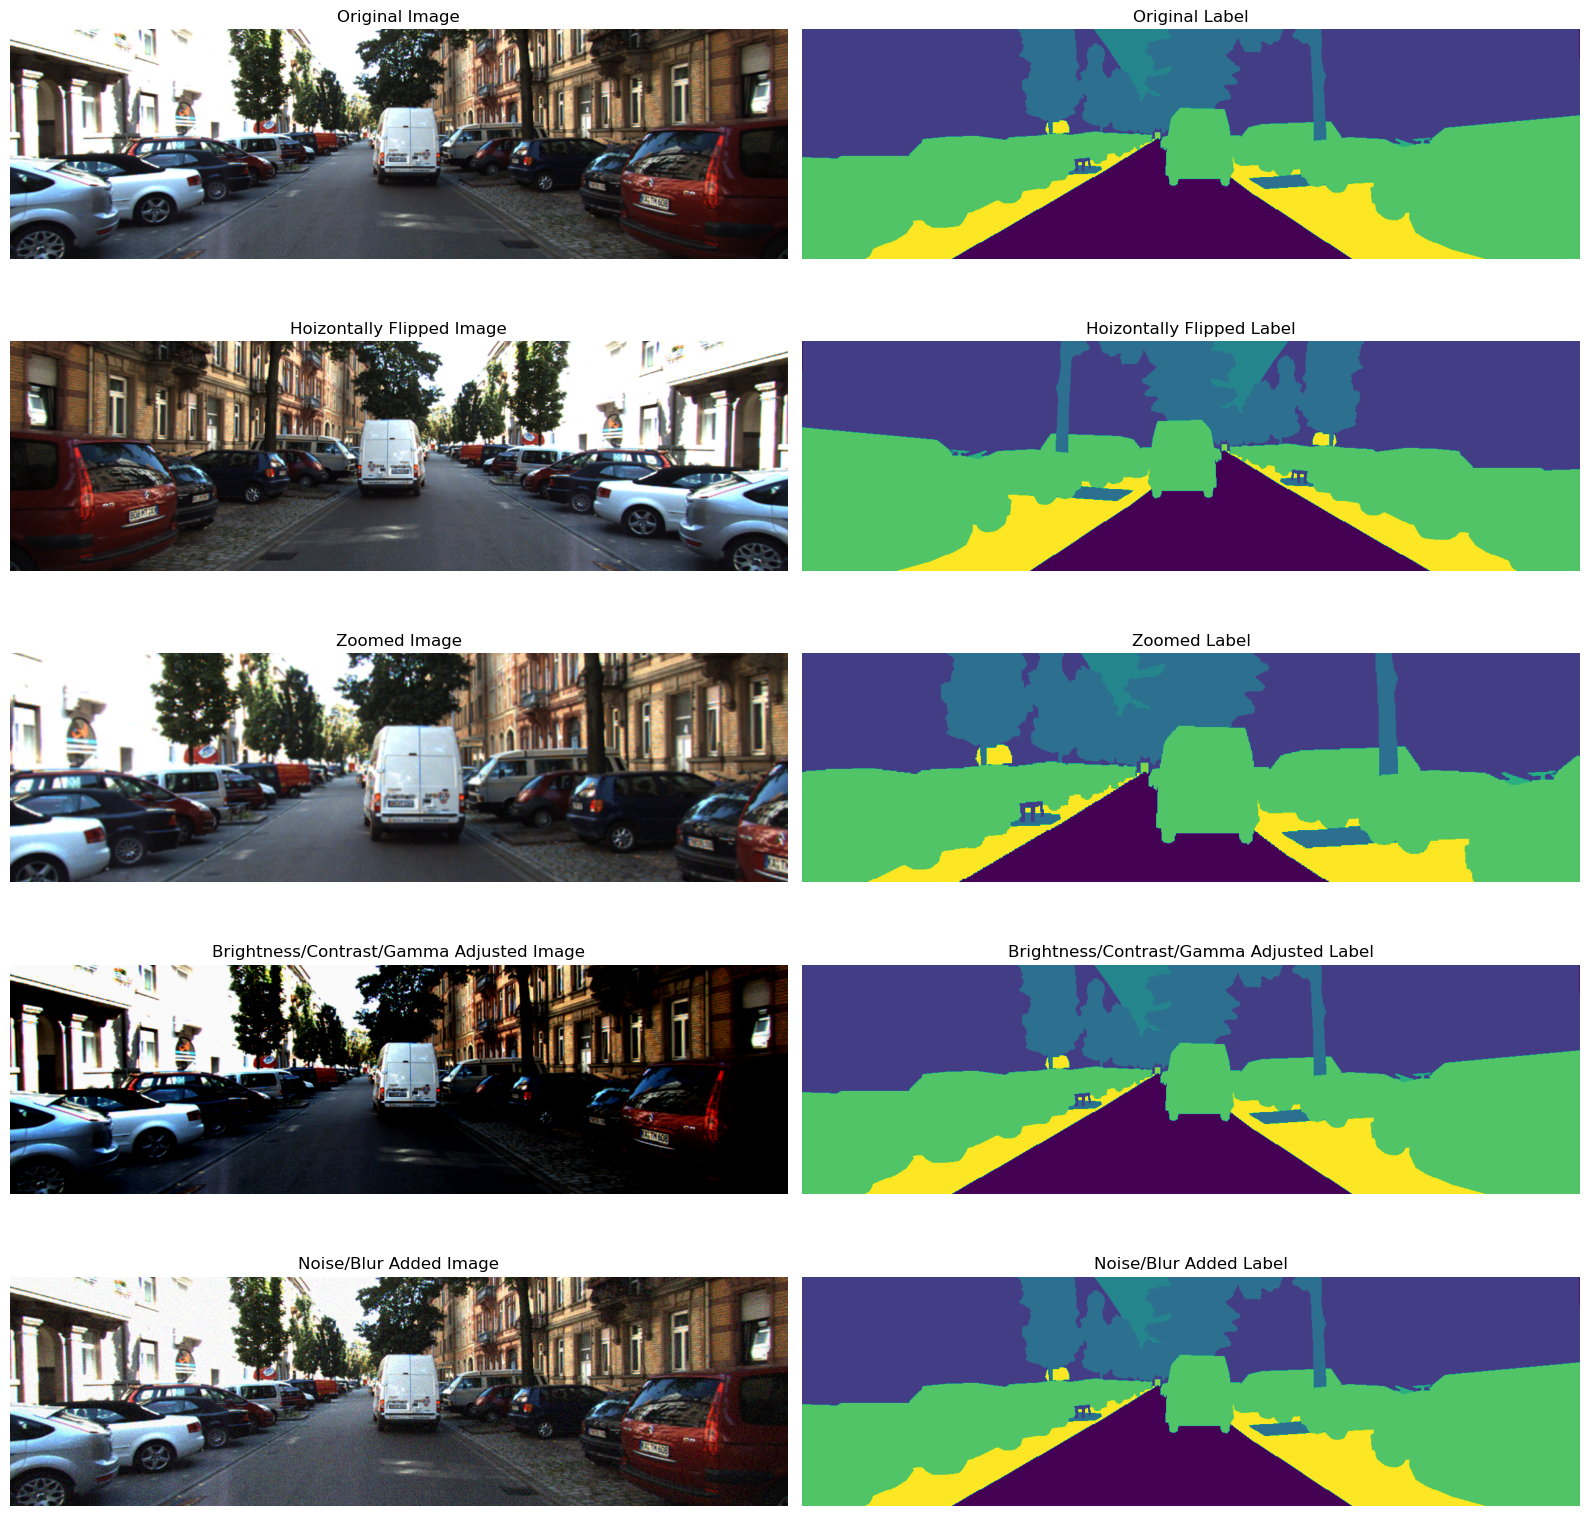

In [34]:
sample_number = tf.random.uniform(shape=[], minval=0, maxval=200, dtype=tf.int32)

sample_image, sample_label = parse_sample(KITTI_image_label_pairs[sample_number][0], KITTI_image_label_pairs[sample_number][1])

image_flip, label_flip = horizontal_flip(sample_image, sample_label, 1)
image_zoom, label_zoom = random_zoom(sample_image, sample_label, 1)
image_light, label_light = brightness_contrast_gamma(sample_image, sample_label, 1)
image_noise, label_noise = random_noise_blur(sample_image, sample_label, 1)

image_label_pairs = [
    (sample_image, sample_label, "Original"),
    (image_flip, label_flip, "Hoizontally Flipped"),
    (image_zoom, label_zoom, "Zoomed"),
    (image_light, label_light, "Brightness/Contrast/Gamma Adjusted"),
    (image_noise, label_noise, "Noise/Blur Added")
]

fig, axs = plot.subplots(len(image_label_pairs), 2, figsize=(16, 16))

# Loop over the image-label pairs
for i, (image, label, title) in enumerate(image_label_pairs):
    # Image
    axs[i,0].imshow(image.numpy())
    axs[i,0].set_title(f"{title} Image")
    axs[i,0].axis('off')

    # Label
    axs[i,1].imshow(label.numpy())
    axs[i,1].set_title(f"{title} Label")
    axs[i,1].axis('off')

# Adjust layout for better spacing
plot.tight_layout()
plot.show()

The augmentation wrapper applies the augmentations in order, with horizontal flipping applied first. Each augmentation has an individual probability.

In [ ]:
def augmentation_wrapper(image, label):

    image, label = horizontal_flip(image, label, flip_prob) 
    image, label = random_zoom(image, label, zoom_prob)
    image, label = brightness_contrast_gamma(image, label, light_prob)
    image, label = random_noise_blur(image, label, noise_prob)
        
    return image, label

A data pipeline is built for efficient loading, preprocessing, and batching of images and their corresponding labels. First the image and label paths are converted into a dataset of tuples, which is shuffled to ensure that the samples are presented in a random order during training. The resulting dataset is then parsed with the number of parallel calls set to 'AUTOTUNE' to optimize performance. The augmentations are then applied on the dataset based on the boolean value of the corresponding variable. If the boolean is true, the augmented dataset is added to the original dataset (in this case 50% of the original dataset size). The normalization function is applied and then multiple samples of the dataset are combined into a single batch. Finally, the dataset is prefetched to improve performance by preparing the next batch of data while the current batch is being processed.

In [ ]:
#Taken from ACDC Course with modifications

def create_dataset(image_label_pairs, batch_size, buffer_size=200, do_augmentation=False):
    
    image_path_list = []
    label_path_list = []

    for iterator in image_label_pairs:
        image_path_list.append(iterator[0])
        label_path_list.append(iterator[1])
        dataset = tf.data.Dataset.from_tensor_slices((image_path_list, label_path_list))
    
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation policy
    if do_augmentation:
        aug_dataset = dataset.take(tf.data.experimental.cardinality(dataset).numpy()//2)
        aug_dataset = aug_dataset.map(augmentation_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.concatenate(aug_dataset)
        dataset = dataset.shuffle(buffer_size=200)

    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)
    # Use prefetching
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*MR6_IaOCoxbXRPuFbIJlUg.jpeg" width ="700">

[Fig. 3: Encoder-Decoder Architecture](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*MR6_IaOCoxbXRPuFbIJlUg.jpeg)

The above image illustrates an encoder-decoder architecture where the encoder extracts and compresses input features and subsequently the decoder reconstructs the output from these features. 

The encoder function builds the downsampling part of the U-Net architecture.
First, the current tensor is initialized with the input tensor and a list is created to store the output of each layer in the encoder. Then 2-dimensional convolutional layers are successively created over the depth of the encoder. L2 regularization is also used to penalize large weights, reducing overfitting. Batch normalization is applied to the output of every convolution layer, thus stabilizing and speeding up training. After each pair of convolutional layers, the max pooling operation downsamples the feature map to half its original spatial dimensions. Dropout randomly drops a fraction of the input units at each update during training, which helps prevent overfitting.

The decoder function reconstructs the high-resolution output from the compressed features generated by the encoder. It starts with the deepest layer of the encoder which contains the most compressed representation of the input features. The layers undergo successive upsampling over the depth of the network, thus increasing the spatial dimensions while reducing the number of filters. The output of the current layer in the decoder is concatenated with the corresponding layer from the encoder. This skip connection helps retain spatial information that might have been lost during downsampling in the encoder. Convolution layers are then applied to refine the features further. Finally, batch normalization and dropout are applied to normalize activations and prevent overfitting respectively.

In [ ]:
#Code taken from ACDC Course with modifications

def encoder(input,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout,
            l2_weight_decay):  # Add weight_decay parameter

    t = input
    encoder_layers = udepth * [None]

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation,
                   kernel_regularizer=l2(l2_weight_decay))(t)  # Add weight decay
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation,
                   kernel_regularizer=l2(l2_weight_decay))(t)  # Add weight decay
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers

def decoder(encoder_layers,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout,
            l2_weight_decay):  # Add weight_decay parameter

    # start at lowest encoder layer
    t = encoder_layers[udepth - 1]

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth - 1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=(2, 2),
                            padding="same",
                            kernel_regularizer=l2(l2_weight_decay))(t)  # Add weight decay

        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation,
                   kernel_regularizer=l2(l2_weight_decay))(t)  # Add weight decay
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation,
                   kernel_regularizer=l2(l2_weight_decay))(t)  # Add weight decay
        t = BatchNormalization()(t) if batch_norm else t

    return t


This function assembles the U-Net architecture and returns a Keras model which can be trained, saved and loaded.

In [ ]:
#Code taken from ACDC Course with modifications

def getModel(input_shape,
             num_classes,
             udepth,
             filters1,
             kernel_size,
             activation,
             batch_norm=True,
             dropout = 0.1,
             l2_weight_decay = 0):  # Add l2_weight_decay parameter

    
    # create input layer
    input_tensor = Input(shape=input_shape)

    # construct encoder
    encoder_layers = encoder(input=input_tensor,
                             udepth=udepth,
                             filters1=filters1,
                             kernel_size=kernel_size,
                             activation=activation,
                             batch_norm=batch_norm,
                             dropout=dropout,
                             l2_weight_decay=l2_weight_decay  # Pass l2_weight_decay
                            )

    # construct decoder
    reconstruction = decoder(encoder_layers=encoder_layers,
                             udepth=udepth,
                             filters1=filters1,
                             kernel_size=kernel_size,
                             activation=activation,
                             batch_norm=batch_norm,
                             dropout=dropout,
                             l2_weight_decay=l2_weight_decay  # Pass l2_weight_decay
                            )

    # build final prediction layer
    logits = Conv2D(filters=num_classes,
                    kernel_size=kernel_size,
                    padding="same",
                    activation=activation)(reconstruction)
    
    # apply softmax activation function to the logits 
    probabilities = Activation("softmax")(logits)
    
    # create a Keras model
    segmentation_model = Model(inputs=input_tensor, outputs=probabilities)
    
    return segmentation_model


The following function is used to define, compile, and train the CNN model. The image-label input is set to (368, 1248, 3), which translates to the pairs having a  size of 368x1248 with 3 color channels. The model is compiled using the Adam optimizer with a specified learning rate, with the appropriate loss function and evaluation metric for segmentation tasks. Adam combines the advantages of AdaGrad (adaptive learning rates) and RMSProp (gradient normalization). Callback functions depending on validation loss are implemented. 'EarlyStopping' stops training when the validation loss stops improving, thus preventing overfitting.'ReduceLROnPlateau' reduces the learning rate when a plateau in the validation loss is detected. The model is then trained with the input training and validation datasets. After training, the history of training metrics (Mean Intersection over Union and loss) is recorded. The sparse cross entropy loss function is used since there are multiple classes and the labels are in the form of one-hot representations.  

In [ ]:
def CNN_model(num_classes, udepth, filters1, kernel_size, activation, dropout, weight_decay, training_dataset, validation_dataset, batch_size, epochs = 1000, early_stopping_patience = 10, reduce_lr_patience = 5, learning_rate = 0.001):
    # Model Definition
    model = getModel(input_shape=(368, 1248, 3),
                 num_classes=num_classes,
                 udepth=udepth,
                 filters1=filters1,
                 kernel_size=kernel_size,
                 activation=activation,
                 batch_norm=True,
                 dropout=dropout,
                 l2_weight_decay=weight_decay)
    # print(model.summary())

    # Model Compiling
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=reduce_lr_patience)
    best_metrics_callback = BestMetricsCallback()

    # Model Training
    history = model.fit(training_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    callbacks=[early_stopping, reduce_lr, best_metrics_callback],
                    batch_size = batch_size,
                    verbose = 1
                    )
    
    train_miou = history.history.get('MIoU')
    train_loss = history.history.get('loss')
    val_miou = history.history.get('val_MIoU')
    val_loss = history.history.get('val_loss')

    best_epoch = best_metrics_callback.best_epoch
    best_learning_rate = best_metrics_callback.best_learning_rate
    
    return model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate

    # train_miou: List of floats
    # train_loss: List of floats
    # val_miou: List of floats
    # val_loss: List of floats
    # best_epoch: Integer
    # best_learning_rate: Float


A class called 'BestMetricsCallback' is created to return the best metric values from the model training history.

In [ ]:
# Taken from ChatGPT

class BestMetricsCallback(Callback):
    def __init__(self):
        super(BestMetricsCallback, self).__init__()
        self.best_val_loss = float('inf')
        self.best_epoch = -1
        self.best_learning_rate = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        
        # Update best validation loss and corresponding learning rate and epoch
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_epoch = epoch + 1  # epoch is zero-indexed, so add 1 for human-friendly output
            self.best_learning_rate = current_lr

### **Experiments**

The functions defined in the 'Methodology' section will be used to train the CNN models. A base model is trained as a reference for each dataset as input. The following dataset combinations are used:
1. KITTI Training and CityScape Subset Validation <br>
2. Cityscape Subset Training and KITTI Validation <br>
3. Merged Training and Merged Validation <br>

For hyperparameter tuning, the depth of neural network (5) and number of filters (16) is kept constant. A base learning rate of 0.001 is set, which reduces over the course of training depending on the validation loss. A grid search is done on dropout rate, weight decay and batch size to find the optimum parameter values. A grid search is performed on the list of values for batch size, neural network dropout rate and weight decay. As seen below, dropout values in steps of 0.1 between 0 and 0.9, weight decay values from 0 to 1e-9 in logarithmic steps, and batch size in powers of 2 up to 32 are used. The MIoU and loss values are validated for each model with plots against each hyperparameter value. [Fig. 4](https://gombru.github.io/assets/cross_entropy_loss/intro.png) illustrates the cross entropy loss function. MIoU is the average of the IoUs (Intersections over Unions) of each individual class.  The IoU is defined as the ratio of the intersection of the predicted and true label areas to their union. [[5]](https://arxiv.org/abs/1505.04597) With the optimum parameters, augmentations are applied to figure out the optimum combination of augmentations.

<br>
<img src="https://gombru.github.io/assets/cross_entropy_loss/intro.png" width ="700">

[Fig. 4: Cross Entropy Loss Function in CNN](https://gombru.github.io/assets/cross_entropy_loss/intro.png)


After every grid search, a plot is generated to analyze the change in loss and MIoU metrics with increasing or changing parameter values. The optimum parameter is selected by comparing the validation loss of each parameter.

In [ ]:
!mkdir models

# Fixed Hyper Parameters (Neural Network Architecture)
udepth = 5
filters1 = 16
kernel_size = (3, 3)
activation = tf.nn.relu
base_learning_rate = 0.001

# Hyper Parameter Space
dropout_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_decay_list = [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1]
batch_size_list = [2, 4, 6, 8, 16, 32]

## 1. KITTI Training Dataset and CityScape Validation Dataset

The base model with no augmentations is trained with default parameters stated in the code below. 

In [ ]:
!cd models && mkdir KITTI_Train_CityScape_Val

training_image_label_pairs = KITTI_training_image_label_pairs
validation_image_label_pairs = CityScape_subset_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

# Base Model Hyper Parameters
dropout = 0.1
weight_decay = 0
batch_size = 4

In [ ]:
#Cell to test model training for the examiner

training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())

#Validation Dataset Creation
validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())

#Test Dataset
test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)

#Training base model
model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate = CNN_model(num_classes, udepth, filters1, kernel_size, activation, dropout, weight_decay, training_dataset, validation_dataset, batch_size) 

In [ ]:
# KITTI-CityScape Dataset Base Model

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/KITTI_CityScape_Base_Model.weights.h5"):
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())
    
    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    
    #Training base model
    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate = CNN_model(num_classes, udepth, filters1, kernel_size, activation, dropout, weight_decay, training_dataset, validation_dataset, batch_size) 
    
    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
    
    print("Best learning rate: ",best_learning_rate)
    print("Training Loss: ",train_loss[best_epoch-1])
    print("Training MIoU: ",train_miou[best_epoch-1])
    print("Validation Loss: ",val_loss[best_epoch-1])
    print("Validation MIoU: ",val_miou[best_epoch-1])
    print("Test Loss: ",test_loss)
    print("Test MIoU: ",test_miou)
    print("Total Epochs: ",(best_epoch + 10))

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/KITTI_Train_CityScape_Val/KITTI_CityScape_Base_Model_results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best learning rate: {best_learning_rate}\n")
        file.write(f"Training Loss: {train_loss[best_epoch-1]}\n")
        file.write(f"Training MIoU: {train_miou[best_epoch-1]}\n")
        file.write(f"Validation Loss: {val_loss[best_epoch-1]}\n")
        file.write(f"Validation MIoU: {val_miou[best_epoch-1]}\n")
        file.write(f"Test Loss: {test_loss}\n")
        file.write(f"Test MIoU: {test_miou}\n")
        file.write(f"Total Epochs: {best_epoch+10}\n")
    # Save Model
    model.save_weights(os.getcwd()+"/models/KITTI_Train_CityScape_Val/KITTI_CityScape_Base_Model.weights.h5")

else:
    print("Base Model already trained.")

In [ ]:
Base_Model_1 = getModel(input_shape=(368, 1248, 3),
                num_classes = num_classes,
                udepth = udepth,
                filters1 = filters1,
                kernel_size = kernel_size,
                activation = activation,
                batch_norm=True,
                dropout = dropout,
                l2_weight_decay = weight_decay)
with open(os.getcwd()+'/models/KITTI_Train_CityScape_Val/KITTI_CityScape_Base_Model_results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best learning rate'):
                best_learning_rate = float(line.split(':')[-1].strip())
Base_Model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
Base_Model_1.load_weights(os.getcwd()+'/models/KITTI_Train_CityScape_Val/KITTI_CityScape_Base_Model.weights.h5')

### a. Tuning Batch Size of Dataset

In [ ]:
#Create new folders

!cd models/KITTI_Train_CityScape_Val && mkdir "batchsize tuning"
!cd models/KITTI_Train_CityScape_Val/"batchsize tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    for batch_size in batch_size_list:

        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)

        #Validation Dataset Creation
        validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)

        #Test Dataset
        test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
        
        print("Model with batch size = ", batch_size)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/KITTI_Train_CityScape_Val/batchsize tuning/weights/'+'batchsize_'+str(batch_size_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/KITTI_Train_CityScape_Val/batchsize tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Batch Size'):
                best_batch_size = int(line.split(':')[-1].strip())

    print("Best Batch Size: ",best_batch_size)

The following function defines the graph plots for loss and MIoU against the respective parameter values in the form of line graph. 

In [ ]:
# Plotting functions for Hyperparameter tuning
def plot_loss_data(x_lists):
    
    plot.figure(figsize=(10, 6))
    
    # Plot Training Loss
    plot.plot(x_lists, train_loss_list, marker='o', linestyle='--', color='black', label = 'Training Loss')
    
    # Plot Validation Loss
    plot.plot(x_lists, valid_loss_list, marker='o', linestyle='--', color='blue', label = 'Validation Loss')

    # Plot Validation Loss
    plot.plot(x_lists, test_loss_list, marker='o', linestyle='--', color='red', label = 'Test Loss')

def plot_miou_data(x_lists):
    
    plot.figure(figsize=(10, 6))
    
    # Plot Training Loss
    plot.plot(x_lists, train_miou_list, marker='o', linestyle='--', color='black', label = 'Training MIoU')
    
    # Plot Validation Loss
    plot.plot(x_lists, valid_miou_list, marker='o', linestyle='--', color='blue', label = 'Validation MIoU')

    # Plot Test Loss
    plot.plot(x_lists, test_miou_list, marker='o', linestyle='--', color='red', label = 'Test MIoU')   

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/batch_size_vs_Loss.jpg"):
    plot_loss_data(batch_size_list)
    plot.xlabel('Batch Size')
    plot.ylabel('Loss')
    plot.title('Batch Size vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/batch_size_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+'/models/KITTI_Train_CityScape_Val/batchsize tuning/batch_size_vs_Loss.jpg')

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/batch_size_vs_MIoU.jpg"):
    plot_miou_data(batch_size_list)
    plot.xlabel('Batch Size')
    plot.ylabel('MIoU')
    plot.title('Batch Size vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/batch_size_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/batch_size_vs_MIoU.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/batchsize tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_batch_size = batch_size_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    total_epochs = epoch_list[index_of_best_model]

    print("Best Batch Size: ",best_batch_size)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)
    print("Total Epochs: ",total_epochs)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/batchsize tuning/best_batchsize_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/KITTI_Train_CityScape_Val/batchsize tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Batch Size: {best_batch_size}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
else:
    print("Results already stored in file")

### b. Tuning of Neural Network Dropout Rate

In [ ]:
#Create new folders

!cd models/KITTI_Train_CityScape_Val && mkdir "dropout tuning"
!cd models/KITTI_Train_CityScape_Val/"dropout tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    for dropout in dropout_list:

        print("Model with dropout = ", dropout)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    best_batch_size)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/KITTI_Train_CityScape_Val/dropout tuning/weights/'+'dropout_'+str(dropout_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/KITTI_Train_CityScape_Val/dropout tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Dropout'):
                best_dropout = float(line.split(':')[-1].strip())

    print("Best Dropout: ",best_dropout)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/dropout_vs_Loss.jpg"):
    plot_loss_data(dropout_list)
    plot.xlabel('Dropout')
    plot.ylabel('Loss')
    plot.title('Dropout vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/dropout_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/dropout_vs_Loss.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/dropout_vs_MIoU.jpg"):
    plot_miou_data(dropout_list)
    plot.xlabel('Dropout')
    plot.ylabel('MIoU')
    plot.title('Dropout vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/dropout_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/dropout_vs_MIoU.jpg")
    
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/dropout tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_dropout = dropout_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    total_epochs = epoch_list[index_of_best_model]

    print("Best Dropout: ",best_dropout)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)
    print("Total Epochs: ",total_epochs)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/dropout tuning/best_dropout_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/KITTI_Train_CityScape_Val/dropout tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Dropout: {best_dropout}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
else:
    print("Results already stored in file")

### c. Tuning Neural Network Weight Decay

In [ ]:
#Create new folders

!cd models/KITTI_Train_CityScape_Val && mkdir "weight_decay tuning"
!cd models/KITTI_Train_CityScape_Val/"weight_decay tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)
    
    for weight_decay in weight_decay_list:

        print("Model with weight_decay = ", weight_decay)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, best_dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    best_batch_size)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/KITTI_Train_CityScape_Val/weight_decay tuning/weights/'+'weight_decay_'+str(weight_decay_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/KITTI_Train_CityScape_Val/weight_decay tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Weight Decay'):
                best_weight_decay = float(line.split(':')[-1].strip())

    print("Best Weight Decay: ",best_weight_decay)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/weight_decay_vs_Loss.jpg"):
    plot_loss_data(weight_decay_list)
    plot.xscale('log')
    plot.xlabel('Weight Decay')
    plot.ylabel('Loss')
    plot.title('Weight Decay vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/weight_decay_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/weight_decay_vs_Loss.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg"):
    plot_miou_data(weight_decay_list)
    plot.xscale('log')
    plot.xlabel('Weight Decay')
    plot.ylabel('MIoU')
    plot.title('Weight Decay vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/weight_decay tuning/results.txt"):
    best_test_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_weight_decay = weight_decay_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    total_epochs = epoch_list[index_of_best_model]

    print("Best Weight Decay: ",best_weight_decay)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)
    print("Total Epochs: ",total_epochs)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/weight_decay tuning/best_weight_decay_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/KITTI_Train_CityScape_Val/weight_decay tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Weight Decay: {best_weight_decay}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
else:
    print("Results already stored in file")

The following cell gives the best hyperparameters for the model with KITTI training and CityScape subset validation datasets.

In [ ]:
print(f"Best Batch Size {best_batch_size}\nBest Dropout Rate {best_dropout}\nBest Weight Decay {best_weight_decay}")

### d. Augmentations

The augmentations are individually applied on a random half of the dataset, which is then appended to the original dataset. From the obtained results, further combinations are experimented to find the optimum combination of augmentations. The validation loss and MIoU are analyzed against each augmentation, and the best augmentation(s) are combined with the other augmentations till the optimum combination is found.

In [ ]:
!cd models && mkdir KITTI_Train_CityScape_Val
!cd models/KITTI_Train_CityScape_Val && mkdir augmentations
!cd models/KITTI_Train_CityScape_Val/augmentations && mkdir weights

training_image_label_pairs = KITTI_training_image_label_pairs
validation_image_label_pairs = CityScape_subset_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

# Tuned Hyper Parameters
udepth = 5
filters1 = 16
dropout = 0.5
weight_decay = 0.0000001
batch_size = 4
base_learning_rate = 0.001

kernel_size = (3, 3)
activation = tf.nn.relu

#Validation Dataset Creation
validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())
    

#ika Test Dataset
test_dataset = create_dataset(ika_test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Test Dataset Length:", tf.data.experimental.cardinality(test_dataset).numpy())

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_single.jpg"):
            
    flip_prob = zoom_prob = light_prob = noise_prob = 0
    prob_list = [0,0,0,0]
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]
            

    model_list = []
    aug_names_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    model_processing_time = []
    epoch_list = []


    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        flip_prob = prob_list[0]
        zoom_prob = prob_list[1]
        light_prob = prob_list[2]
        noise_prob = prob_list[3]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

The following functions define graph plots for loss and MIoU against the respective augmentation technique/s in the form of bar graphs.

In [ ]:
# Plotting function for Augmentations
def plot_loss_aug(x_lists):

    # Positions of the bars on the x-axis
    ind = npy.arange(len(x_lists))

    # Width of a bar
    width = 0.1

    # Create a bar chart
    plot.figure(figsize=(20, 6))
    
    plot.xticks(ind, x_lists)

    # Plot Training Loss
    plot.bar(ind - width, train_loss_list, width, color='black', label='Training Loss')

    # Plot Validation Loss
    plot.bar(ind, valid_loss_list, width, color='blue', label='Validation Loss')

    # Plot Test Loss
    plot.bar(ind + width, test_loss_list, width, color='red', label='Test Loss')
    
   
def plot_miou_aug(x_lists):

    # Positions of the bars on the x-axis
    ind = npy.arange(len(x_lists))

    # Width of a bar
    width = 0.1

    # Create a bar chart
    plot.figure(figsize=(20, 6))
    
    plot.xticks(ind, x_lists)

    # Plot Training Loss
    plot.bar(ind - width, train_miou_list, width, color='black', label='Training MIoU')

    # Plot Validation Loss
    plot.bar(ind, valid_miou_list, width, color='blue', label='Validation MIoU')

    # Plot Test Loss
    plot.bar(ind + width, test_miou_list, width, color='red', label='Test MIoU')

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_single.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_single.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_single.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_single.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_single.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_single.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_double.jpg"):
    
    
    #In combination with Flip
    flip_prob = 1
    zoom_prob = light_prob = noise_prob = 0
    prob_list = [0,0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        zoom_prob = prob_list[0]
        light_prob = prob_list[1]
        noise_prob = prob_list[2]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1
        
        
        
        
    #In combination with noise
    noise_prob = 1
    flip_prob = light_prob = zoom_prob = 0
    prob_list = [0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        zoom_prob = prob_list[0]
        light_prob = prob_list[1]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_double.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_double.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_double.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_double.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_double.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_double.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_final.jpg"):
    
    
    flip_prob = noise_prob = 1
    zoom_prob = light_prob = 0
    prob_list = [0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        zoom_prob = prob_list[0]
        light_prob = prob_list[1]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1
        
        
        
        
    #All augmentations
    noise_prob = flip_prob = light_prob = zoom_prob = 1
    file_name = 'All augments'

    print("Model augmented with:", file_name)
    print(flip_prob, zoom_prob, light_prob, noise_prob)
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                activation, dropout, weight_decay, 
                                                                                                training_dataset, validation_dataset, 
                                                                                                batch_size)

    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
    model_list.append(model)
    aug_names_list.append(file_name)
    train_miou_list.append(train_miou[best_epoch-1])
    train_loss_list.append(train_loss[best_epoch-1])
    valid_miou_list.append(val_miou[best_epoch-1])
    valid_loss_list.append(val_loss[best_epoch-1])
    test_miou_list.append(test_miou)
    test_loss_list.append(test_loss)
    learning_rate_list.append(best_learning_rate)
    epoch_list.append((best_epoch + 10))

    file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
    model_list[index].save_weights(file_path)
    index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_final.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_final.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/Loss_final.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_final.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_final.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/graphs/MIoU_final.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/augmentations/results.txt"):
    best_test_loss = 1000
    index = 0

    while index < len(model_list):
        if test_loss_list[index] < best_test_loss:
            index_of_best_model = index
            best_test_loss = test_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_augmentation = aug_names_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]

    print("Best Augmentation: ",best_augmentation)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/best_augmentation_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Augmentation: {best_augmentation}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        
else:
    print("Results already stored in file")
    with open(os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Augmentation'):
                best_aug = str(line.split(':')[-1].strip())

    print("Best Augmentation: ",best_aug)

## 2. CityScape Training Dataset and KITTI Validation Dataset

Now the second set of datasets are used: the CityScape subset training dataset and KITTI validation datasets. The same sets of experiments implemented previously are conducted here.

In [ ]:
!cd models && mkdir CityScape_Train_KITTI_Val

training_image_label_pairs = CityScape_subset_training_image_label_pairs
validation_image_label_pairs = KITTI_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

# Base Model Hyper Parameters
dropout = 0.1
weight_decay = 0
batch_size = 4

In [ ]:
#Cell to test model training for the examiner

training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())

#Validation Dataset Creation
validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())

#Test Dataset
test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)

#Training base model
model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate = CNN_model(num_classes, udepth, filters1, kernel_size, activation, dropout, weight_decay, training_dataset, validation_dataset, batch_size) 

In [ ]:
# CityScape-KITTI Dataset Base Model

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/CityScape_KITTI_Base_Model.weights.h5"):
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())
    
    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    

    #Training base model
    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate = CNN_model(num_classes, udepth, filters1, kernel_size, activation, dropout, weight_decay, training_dataset, validation_dataset, batch_size) 
    
    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
    
    print("Best learning rate: ",best_learning_rate)
    print("Training Loss: ",train_loss[best_epoch-1])
    print("Training MIoU: ",train_miou[best_epoch-1])
    print("Validation Loss: ",val_loss[best_epoch-1])
    print("Validation MIoU: ",val_miou[best_epoch-1])
    print("Test Loss: ",test_loss)
    print("Test MIoU: ",test_miou)
    print("Total Epochs: ",(best_epoch + 10))

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/CityScape_Train_KITTI_Val/CityScape_KITTI_Base_Model_results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best learning rate: {best_learning_rate}\n")
        file.write(f"Training Loss: {train_loss[best_epoch-1]}\n")
        file.write(f"Training MIoU: {train_miou[best_epoch-1]}\n")
        file.write(f"Validation Loss: {val_loss[best_epoch-1]}\n")
        file.write(f"Validation MIoU: {val_miou[best_epoch-1]}\n")
        file.write(f"Test Loss: {test_loss}\n")
        file.write(f"Test MIoU: {test_miou}\n")
        file.write(f"Total Epochs: {best_epoch+10}\n")
    # Save Model
    model.save_weights(os.getcwd()+"/models/CityScape_Train_KITTI_Val/CityScape_KITTI_Base_Model.weights.h5")

else:
    
    print("Base Model already trained.")

In [ ]:
Base_Model_2 = getModel(input_shape=(368, 1248, 3),
                num_classes = num_classes,
                udepth = udepth,
                filters1 = filters1,
                kernel_size = kernel_size,
                activation = activation,
                batch_norm=True,
                dropout = dropout,
                l2_weight_decay = weight_decay)
with open(os.getcwd()+'/models/CityScape_Train_KITTI_Val/CityScape_KITTI_Base_Model_results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best learning rate'):
                best_learning_rate = float(line.split(':')[-1].strip())
Base_Model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
Base_Model_2.load_weights(os.getcwd()+'/models/CityScape_Train_KITTI_Val/CityScape_KITTI_Base_Model.weights.h5')


### a. Tuning Batch Size of Dataset

In [ ]:
#Create new folders

!cd models/CityScape_Train_KITTI_Val && mkdir "batchsize tuning"
!cd models/CityScape_Train_KITTI_Val/"batchsize tuning" && mkdir weights



if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    for batch_size in batch_size_list:

        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)

        #Validation Dataset Creation
        validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)

        #Test Dataset
        test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
        
        print("Model with batch size = ", batch_size)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/CityScape_Train_KITTI_Val/batchsize tuning/weights/'+'batchsize_'+str(batch_size_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/CityScape_Train_KITTI_Val/batchsize tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Batch Size'):
                best_batch_size = int(line.split(':')[-1].strip())

    print("Best Batch Size: ",best_batch_size)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/batch_size_vs_Loss.jpg"):
    plot_loss_data(batch_size_list)
    plot.xlabel('Batch Size')
    plot.ylabel('Loss')
    plot.title('Batch Size vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/batch_size_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+'/models/CityScape_Train_KITTI_Val/batchsize tuning/batch_size_vs_Loss.jpg')

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/batch_size_vs_MIoU.jpg"):
    plot_miou_data(batch_size_list)
    plot.xlabel('Batch Size')
    plot.ylabel('MIoU')
    plot.title('Batch Size vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/batch_size_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/batch_size_vs_MIoU.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/batchsize tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_batch_size = batch_size_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    total_epochs = epoch_list[index_of_best_model]

    print("Best Batch Size: ",best_batch_size)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)
    print("Total Epochs: ",total_epochs)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/batchsize tuning/best_batchsize_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/CityScape_Train_KITTI_Val/batchsize tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Batch Size: {best_batch_size}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
else:
    print("Results already stored in file")

### b. Tuning of Neural Network Dropout Rate

In [ ]:
#Create new folders

!cd models/CityScape_Train_KITTI_Val && mkdir "dropout tuning"
!cd models/CityScape_Train_KITTI_Val/"dropout tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    for dropout in dropout_list:

        print("Model with dropout = ", dropout)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    best_batch_size)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/CityScape_Train_KITTI_Val/dropout tuning/weights/'+'dropout_'+str(dropout_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/CityScape_Train_KITTI_Val/dropout tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Dropout'):
                best_dropout = float(line.split(':')[-1].strip())

    print("Best Dropout: ",best_dropout)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/dropout_vs_Loss.jpg"):
    plot_loss_data(dropout_list)
    plot.xlabel('Dropout')
    plot.ylabel('Loss')
    plot.title('Dropout vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/dropout_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/dropout_vs_Loss.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/dropout_vs_MIoU.jpg"):
    plot_miou_data(dropout_list)
    plot.xlabel('Dropout')
    plot.ylabel('MIoU')
    plot.title('Dropout vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/dropout_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/dropout_vs_MIoU.jpg")
    
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/dropout tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_dropout = dropout_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    total_epochs = epoch_list[index_of_best_model]

    print("Best Dropout: ",best_dropout)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)
    print("Total Epochs: ",total_epochs)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/dropout tuning/best_dropout_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/CityScape_Train_KITTI_Val/dropout tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Dropout: {best_dropout}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
else:
    print("Results already stored in file")

### c. Tuning Neural Network Weight Decay

In [ ]:
#Create new folders

!cd models/CityScape_Train_KITTI_Val && mkdir "weight_decay tuning"
!cd models/CityScape_Train_KITTI_Val/"weight_decay tuning" && mkdir weights



if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)
    
    for weight_decay in weight_decay_list:

        print("Model with weight_decay = ", weight_decay)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, best_dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    best_batch_size)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/CityScape_Train_KITTI_Val/weight_decay tuning/weights/'+'weight_decay_'+str(weight_decay_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/CityScape_Train_KITTI_Val/weight_decay tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Weight Decay'):
                best_weight_decay = float(line.split(':')[-1].strip())

    print("Best Weight Decay: ",best_weight_decay)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/weight_decay_vs_Loss.jpg"):
    plot_loss_data(weight_decay_list)
    plot.xscale('log')
    plot.xlabel('Weight Decay')
    plot.ylabel('Loss')
    plot.title('Weight Decay vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/weight_decay_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/weight_decay_vs_Loss.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg"):
    plot_miou_data(weight_decay_list)
    plot.xscale('log')
    plot.xlabel('Weight Decay')
    plot.ylabel('MIoU')
    plot.title('Weight Decay vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/weight_decay tuning/results.txt"):
    best_test_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_weight_decay = weight_decay_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    total_epochs = epoch_list[index_of_best_model]

    print("Best Weight Decay: ",best_weight_decay)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)
    print("Total Epochs: ",total_epochs)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/weight_decay tuning/best_weight_decay_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/CityScape_Train_KITTI_Val/weight_decay tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Weight Decay: {best_weight_decay}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
else:
    print("Results already stored in file")

### d. Augmentations

In [ ]:
!cd models/CityScape_Train_KITTI_Val && mkdir augmentations
!cd models/CityScape_Train_KITTI_Val/augmentations && mkdir weights
!cd models/CityScape_Train_KITTI_Val/augmentations && mkdir graphs 

training_image_label_pairs = CityScape_subset_training_image_label_pairs
validation_image_label_pairs = KITTI_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

# Tuned Hyper Parameters
udepth = 5
filters1 = 16
dropout = 0
weight_decay = 0.000001
batch_size = 4
base_learning_rate = 0.001

kernel_size = (3, 3)
activation = tf.nn.relu

#Validation Dataset Creation
validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())

#ika Test Dataset
test_dataset = create_dataset(ika_test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Test Dataset Length:", tf.data.experimental.cardinality(test_dataset).numpy())

In [ ]:
#Individual Augmentations
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_single.jpg"):
            
    flip_prob = zoom_prob = light_prob = noise_prob = 0
    prob_list = [0,0,0,0]
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]
            

    model_list = []
    aug_names_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    model_processing_time = []
    epoch_list = []


    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        flip_prob = prob_list[0]
        zoom_prob = prob_list[1]
        light_prob = prob_list[2]
        noise_prob = prob_list[3]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_single.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_single.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_single.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_single.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_single.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_single.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_double.jpg"):
    
    
    #In combination with Flip
    flip_prob = 1
    zoom_prob = light_prob = noise_prob = 0
    prob_list = [0,0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        zoom_prob = prob_list[0]
        light_prob = prob_list[1]
        noise_prob = prob_list[2]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_double.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_double.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_double.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_double.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_double.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_double.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_final.jpg"):
    
    #In combination with Flip and Zoom
    flip_prob = zoom_prob = 1
    light_prob = noise_prob = 0
    prob_list = [0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0

    for prob in range(len(prob_list)):

        prob_list = [0] * len(prob_list)

        prob_list[prob] = 1

        light_prob = prob_list[0]
        noise_prob = prob_list[1]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1
        
        
        
    #All augmentations
    noise_prob = flip_prob = light_prob = zoom_prob = 1
    file_name = 'All augments'

    print("Model augmented with:", file_name)
    print(flip_prob, zoom_prob, light_prob, noise_prob)

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                activation, dropout, weight_decay, 
                                                                                                training_dataset, validation_dataset, 
                                                                                                batch_size)

    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
    model_list.append(model)
    aug_names_list.append(file_name)
    train_miou_list.append(train_miou[best_epoch-1])
    train_loss_list.append(train_loss[best_epoch-1])
    valid_miou_list.append(val_miou[best_epoch-1])
    valid_loss_list.append(val_loss[best_epoch-1])
    test_miou_list.append(test_miou)
    test_loss_list.append(test_loss)
    learning_rate_list.append(best_learning_rate)
    epoch_list.append((best_epoch + 10))

    file_path = os.getcwd()+'/models/KITTI_Train_CityScape_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
    model_list[index].save_weights(file_path)
    index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_final.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_final.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/Loss_final.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_final.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_final.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/graphs/MIoU_final.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/augmentations/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_augmentation = aug_names_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]

    print("Best Augmentation: ",best_augmentation)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/CityScape_Train_KITTI_Val/augmentations/best_augmentation_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/CityScape_Train_KITTI_Val/augmentations/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Augmentation: {best_augmentation}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        
else:
    print("Results already stored in file")
    with open(os.getcwd()+'/models/CityScape_Train_KITTI_Val/augmentations/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Augmentation'):
                best_aug = str(line.split(':')[-1].strip())

    print("Best Augmentation: ",best_aug)

## 3. Merged Training Dataset and Merged Validation Dataset

Finally, the merged training and validation datasets are used. In the grid search the models are trained only up to 10 epochs due to the large size of the datasets. Once again, the same process flow is applied.

In [ ]:
!cd models && mkdir Merged_Train_Merged_Val

training_image_label_pairs = merged_training_image_label_pairs
validation_image_label_pairs = merged_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

# Base Model Hyper Parameters
dropout = 0.1
weight_decay = 0
batch_size = 4

In [ ]:
#Cell to test model training for the examiner

training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())

#Validation Dataset Creation
validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())

#Test Dataset
test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)

#Training base model
model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate = CNN_model(num_classes, udepth, filters1, kernel_size, activation, dropout, weight_decay, training_dataset, validation_dataset, batch_size) 

In [ ]:
# Merged-Merged Dataset Base Model

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/Merged_Merged_Base_Model.weights.h5"):
        
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)

    model = getModel(input_shape=(368, 1248, 3),
                num_classes=num_classes,
                udepth=udepth,
                filters1=filters1,
                kernel_size=kernel_size,
                activation=activation,
                batch_norm=True,
                dropout=dropout,
                l2_weight_decay=weight_decay)

    # Model Compiling
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    best_metrics_callback = BestMetricsCallback()

    # Model Training
    history = model.fit(training_dataset, 
                    validation_data = validation_dataset, 
                    epochs = 1000, 
                    callbacks=[early_stopping, best_metrics_callback],
                    batch_size = batch_size,
                    verbose = 1
                    )
    
    best_epoch = best_metrics_callback.best_epoch
    train_miou = history.history.get('MIoU')
    train_loss = history.history.get('loss')
    val_miou = history.history.get('val_MIoU')
    val_loss = history.history.get('val_loss') 
    
    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

    print("Best learning rate: ",best_learning_rate)
    print("Training Loss: ",train_loss[best_epoch-1])
    print("Training MIoU: ",train_miou[best_epoch-1])
    print("Validation Loss: ",val_loss[best_epoch-1])
    print("Validation MIoU: ",val_miou[best_epoch-1])
    print("Test Loss: ",test_loss)
    print("Test MIoU: ",test_miou)
    print("Total Epochs: ",(best_epoch + 10))

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/Merged_Train_Merged_Val/Merged_Merged_Base_Model_results.txt'
    with open(filename, 'w') as file:
        file.write(f"Training Loss: {train_loss[best_epoch-1]}\n")
        file.write(f"Training MIoU: {train_miou[best_epoch-1]}\n")
        file.write(f"Validation Loss: {val_loss[best_epoch-1]}\n")
        file.write(f"Validation MIoU: {val_miou[best_epoch-1]}\n")
        file.write(f"Test Loss: {test_loss}\n")
        file.write(f"Test MIoU: {test_miou}\n")
        file.write(f"Total Epochs: {best_epoch+10}\n")
    # Save Model
    model.save_weights(os.getcwd()+"/models/Merged_Train_Merged_Val/Merged_Merged_Base_Model.weights.h5")

else:
    
    print("Base Model already trained.")

In [ ]:
Base_Model_3 = getModel(input_shape=(368, 1248, 3),
                num_classes = num_classes,
                udepth = udepth,
                filters1 = filters1,
                kernel_size = kernel_size,
                activation = activation,
                batch_norm=True,
                dropout = dropout,
                l2_weight_decay = weight_decay)
with open(os.getcwd()+'/models/Merged_Train_Merged_Val/Merged_Merged_Base_Model_results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best learning rate'):
                best_learning_rate = float(line.split(':')[-1].strip())
Base_Model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
Base_Model_3.load_weights(os.getcwd()+'/models/Merged_Train_Merged_Val/Merged_Merged_Base_Model.weights.h5')


### a. Tuning Batch Size of Dataset

In [ ]:
#Create new folders

!cd models/Merged_Train_Merged_Val && mkdir "batchsize tuning"
!cd models/Merged_Train_Merged_Val/"batchsize tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []

    index = 0

    for batch_size in batch_size_list:

        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = False)

        #Validation Dataset Creation
        validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)

        #Test Dataset
        test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
        
        print("Model with batch size = ", batch_size)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, epochs = 10)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)

        # Save Model Weights
        file_path = 'models/Merged_Train_Merged_Val/batchsize tuning/weights/'+'batchsize_'+str(batch_size_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/Merged_Train_Merged_Val/batchsize tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Batch Size'):
                best_batch_size = int(line.split(':')[-1].strip())

    print("Best Batch Size: ",best_batch_size)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/batch_size_vs_Loss.jpg"):
    plot_loss_data(batch_size_list)
    plot.xlabel('Batch Size')
    plot.ylabel('Loss')
    plot.title('Batch Size vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/batch_size_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+'/models/Merged_Train_Merged_Val/batchsize tuning/batch_size_vs_Loss.jpg')

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/batch_size_vs_MIoU.jpg"):
    plot_miou_data(batch_size_list)
    plot.xlabel('Batch Size')
    plot.ylabel('MIoU')
    plot.title('Batch Size vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/batch_size_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/batch_size_vs_MIoU.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/batchsize tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_batch_size = batch_size_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]

    print("Best Batch Size: ",best_batch_size)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/batchsize tuning/best_batchsize_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/Merged_Train_Merged_Val/batchsize tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Batch Size: {best_batch_size}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        
else:
    print("Results already stored in file")

### b. Tuning of Neural Network Dropout Rate

In [ ]:
#Create new folders

!cd models/Merged_Train_Merged_Val && mkdir "dropout tuning"
!cd models/Merged_Train_Merged_Val/"dropout tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []

    index = 0

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    for dropout in dropout_list:

        print("Model with dropout = ", dropout)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    best_batch_size, epochs = 10)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)

        # Save Model Weights
        file_path = 'models/Merged_Train_Merged_Val/dropout tuning/weights/'+'dropout_'+str(dropout_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/Merged_Train_Merged_Val/dropout tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Dropout'):
                best_dropout = float(line.split(':')[-1].strip())

    print("Best Dropout: ",best_dropout)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/dropout_vs_Loss.jpg"):
    plot_loss_data(dropout_list)
    plot.xlabel('Dropout')
    plot.ylabel('Loss')
    plot.title('Dropout vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/dropout_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/dropout_vs_Loss.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/dropout_vs_MIoU.jpg"):
    plot_miou_data(dropout_list)
    plot.xlabel('Dropout')
    plot.ylabel('MIoU')
    plot.title('Dropout vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/dropout_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/dropout_vs_MIoU.jpg")
    
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/dropout tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_dropout = dropout_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]

    print("Best Dropout: ",best_dropout)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/dropout tuning/best_dropout_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/Merged_Train_Merged_Val/dropout tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Dropout: {best_dropout}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        
else:
    print("Results already stored in file")

### c. Neural Network Weight Decay

In [ ]:
#Create new folders

!cd models/Merged_Train_Merged_Val && mkdir "weight_decay tuning"
!cd models/Merged_Train_Merged_Val/"weight_decay tuning" && mkdir weights


if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/results.txt"):
    model_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    epoch_list = []

    index = 0

    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)

    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = best_batch_size,do_augmentation = False)
    
    for weight_decay in weight_decay_list:

        print("Model with weight_decay = ", weight_decay)
        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, best_dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    best_batch_size, epochs = 10)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)

        model_list.append(model)

        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        # Save Model Weights
        file_path = 'models/Merged_Train_Merged_Val/weight_decay tuning/weights/'+'weight_decay_'+str(weight_decay_list[index])+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Hyper Parameter Tuning already performed. Skipping execution of cell")
    with open(os.getcwd()+'/models/Merged_Train_Merged_Val/weight_decay tuning/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Weight Decay'):
                best_weight_decay = float(line.split(':')[-1].strip())

    print("Best Weight Decay: ",best_weight_decay)

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/weight_decay_vs_Loss.jpg"):
    plot_loss_data(weight_decay_list)
    plot.xscale('log')
    plot.xlabel('Weight Decay')
    plot.ylabel('Loss')
    plot.title('Weight Decay vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/weight_decay_vs_Loss.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/weight_decay_vs_Loss.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg"):
    plot_miou_data(weight_decay_list)
    plot.xscale('log')
    plot.xlabel('Weight Decay')
    plot.ylabel('MIoU')
    plot.title('Weight Decay vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/weight_decay_vs_MIoU.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/weight_decay tuning/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_weight_decay = weight_decay_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]

    print("Best Weight Decay: ",best_weight_decay)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/weight_decay tuning/best_weight_decay_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/Merged_Train_Merged_Val/weight_decay tuning/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Weight Decay: {best_weight_decay}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        
else:
    print("Results already stored in file")

### d. Augmentations

In [ ]:
!cd models && mkdir Merged_Train_Merged_Val
!cd models/Merged_Train_Merged_Val && mkdir augmentations
!cd models/Merged_Train_Merged_Val/augmentations && mkdir weights
!cd models/Merged_Train_Merged_Val/augmentations && mkdir graphs 

training_image_label_pairs = merged_training_image_label_pairs
validation_image_label_pairs = merged_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

# Tuned Hyper Parameters
udepth = 5
filters1 = 16
dropout = 0.1
weight_decay = 0.0000001
batch_size = 6
base_learning_rate = 0.001

kernel_size = (3, 3)
activation = tf.nn.relu

#Validation Dataset Creation
validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Validation Dataset Length:", tf.data.experimental.cardinality(validation_dataset).numpy())

#ika Test Dataset
test_dataset = create_dataset(ika_test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
print("Test Dataset Length:", tf.data.experimental.cardinality(test_dataset).numpy())

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_single.jpg"):
            
    flip_prob = zoom_prob = light_prob = noise_prob = 0
    prob_list = [0,0,0,0]
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]
            

    model_list = []
    aug_names_list = []
    train_miou_list = []
    valid_miou_list = []
    test_miou_list = []
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    learning_rate_list = []
    model_processing_time = []
    epoch_list = []


    index = 0

    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        flip_prob = prob_list[0]
        zoom_prob = prob_list[1]
        light_prob = prob_list[2]
        noise_prob = prob_list[3]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)        
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
        
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, epochs = 10)
        
        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_single.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_single.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_single.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_single.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_single.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_single.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_double.jpg"):
    
    
    #In combination with Lighting
    light_prob = 1
    flip_prob = zoom_prob = noise_prob = 0
    prob_list = [0,0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0
    
    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        flip_prob = prob_list[0]
        zoom_prob = prob_list[1]
        noise_prob = prob_list[2]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
    
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, epochs = 10)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_double.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_double.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_double.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_double.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_double.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_double.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_final.jpg"):
    
    
    #In combination with Flip and Lighting
    flip_prob = light_prob = 1
    zoom_prob = noise_prob = 0
    prob_list = [0,0] 
    prob_name = [" Flip ", " Zoom ", " Lighting ", " Noise "]

    index = 0
    
    for prob in range(len(prob_list)):
    
        prob_list = [0] * len(prob_list)
        
        prob_list[prob] = 1

        zoom_prob = prob_list[0]
        noise_prob = prob_list[1]
        
        aug_list = [flip_prob, zoom_prob, light_prob, noise_prob]
        file_name = ''
        
        for augment in range(len(aug_list)):
            
            if aug_list[augment] == 1:
                
                file_name = file_name + str(prob_name[augment])
            
        print("Model augmented with:", file_name)
    
    
        print(flip_prob, zoom_prob, light_prob, noise_prob)
    
        #Training Dataset Creation
        training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
        print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


        model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, epochs = 10)

        test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
        model_list.append(model)
        aug_names_list.append(file_name)
        train_miou_list.append(train_miou[best_epoch-1])
        train_loss_list.append(train_loss[best_epoch-1])
        valid_miou_list.append(val_miou[best_epoch-1])
        valid_loss_list.append(val_loss[best_epoch-1])
        test_miou_list.append(test_miou)
        test_loss_list.append(test_loss)
        learning_rate_list.append(best_learning_rate)
        epoch_list.append((best_epoch + 10))

        file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
        model_list[index].save_weights(file_path)
        index += 1
    
    
    
    #All augmentations
    noise_prob = flip_prob = light_prob = zoom_prob = 1
    file_name = 'All augments'

    print("Model augmented with:", file_name)
    print(flip_prob, zoom_prob, light_prob, noise_prob)
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())


    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                activation, dropout, weight_decay, 
                                                                                                training_dataset, validation_dataset, 
                                                                                                batch_size, epochs = 10)

    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 0)
    model_list.append(model)
    aug_names_list.append(file_name)
    train_miou_list.append(train_miou[best_epoch-1])
    train_loss_list.append(train_loss[best_epoch-1])
    valid_miou_list.append(val_miou[best_epoch-1])
    valid_loss_list.append(val_loss[best_epoch-1])
    test_miou_list.append(test_miou)
    test_loss_list.append(test_loss)
    learning_rate_list.append(best_learning_rate)
    epoch_list.append((best_epoch + 10))

    file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/weights/'+file_name+'_model_weight.weights.h5'
    model_list[index].save_weights(file_path)

else:
    print("Augmentations already performed. Skipping execution of cell")

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_final.jpg"):
    plot_loss_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('Loss')
    plot.title('Augmentations vs Loss')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_final.jpg")
    plot.show()

else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/Loss_final.jpg")

    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_final.jpg"):
    plot_miou_aug(aug_names_list)
    plot.xlabel('Augmentations')
    plot.ylabel('MIoU')
    plot.title('Augmentations vs MIoU')
    plot.legend()
    plot.grid(axis='y')
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_final.jpg")
    plot.show()
    
else:
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/graphs/MIoU_final.jpg")
                       
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/augmentations/results.txt"):
    best_valid_loss = 100
    index = 0

    while index < len(model_list):
        if valid_loss_list[index] < best_valid_loss:
            index_of_best_model = index
            best_valid_loss = valid_loss_list[index]
        index += 1

    best_model = model_list[index_of_best_model]
    best_augmentation = aug_names_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]
    Train_Loss = train_loss_list[index_of_best_model]
    Train_MIoU = train_miou_list[index_of_best_model]
    Val_Loss = valid_loss_list[index_of_best_model]
    Val_MIoU = valid_miou_list[index_of_best_model]
    Test_loss = test_loss_list[index_of_best_model]
    Test_MIoU = test_miou_list[index_of_best_model]

    print("Best Augmentation: ",best_augmentation)
    print("Training Loss: ",Train_Loss)
    print("Training MIoU: ",Train_MIoU)
    print("Validation Loss: ",Val_Loss)
    print("Validation MIoU: ",Val_MIoU)
    print("Test Loss: ",Test_loss)
    print("Test MIoU: ",Test_MIoU)

    #  Save Best Model Weights
    file_path = os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/best_augmentation_model_weight.weights.h5'
    model_list[index_of_best_model].save_weights(file_path)

    # Open the file in write mode and write the results
    # Saving Results
    filename = os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Augmentation: {best_augmentation}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        
else:
    print("Results already stored in file")
    with open(os.getcwd()+'/models/Merged_Train_Merged_Val/augmentations/results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Augmentation'):
                best_aug = str(line.split(':')[-1].strip())

    print("Best Augmentation: ",best_aug)


### Evaluation


In this section, the previously obtained results are summarized and compared. The following table compares the optimum hyperparameters and combination of augmentations for each model.


| Dataset | Training | Validation | Test | Best Batch Size | Best Dropout Rate | Best Weight Decay | Best Augmentations |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | KITTI | CityScape Subset | IKA | 4 | 0.5 | 1e-07 | Flip + Zoom + Noise |
| 2 | CityScape Subset | KITTI | IKA | 4 | 0 | 1e-06 | Flip + Zoom |
| 3 | Merged | Merged | IKA | 6 | 0.1 | 1e-07 | Lighting |

<br>

The following table compares the test loss function and MIoU metrics among the best models. The best performing metrics are highlighted. Dataset 1, 2 and 3 are referenced in the previous table.

| Dataset | Base Model Test Loss | Base Model Test MIoU | Hyperparameter Tuning Test Loss | Hyperparameter Tuning Test MIoU | Augmentations Test Loss | Augmentations Test MIoU |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 1.634658 | 0.106426 | 1.448689 | ***0.215391*** | ***1.283515*** | 0.210903 |
| 2 | 1.672558 | 0.199039 | ***1.364190*** | ***0.264105*** | 1.449450 | 0.260079 |
| 3 | 0.633861 | ***0.478815*** | 0.701467 | 0.421821 | ***0.597180*** | 0.470139 |

Dataset 1 shows significant decrease in test loss with both hyperparameter tuning and augmentation models as compared to the base model.. However the test MIoU remain almost the same between hyperparameter tuning and augmentation. The combination of augmentations for which it shows the best performance is horizontal flip, random zoom, and random noise and blur. 

There is improvement in both test metrics in the model with hyperparameter tuning as compared to the base model. However there was an increase in test loss in the best augmentations model, where the dataset is augmented with horizontal flip and random zoom. This was an anomaly since the validation metrics showed improvements in the augmentation model as compared to the hyperparameters model. The augmented model is further used since it uses a slightly bigger dataset and covers more scenarios due to the augmentations.

The models with merged dataset showed the best training metrics out of all the models due to its size and diversity. Comparing among the models of the same dataset, there is no improvement upon hyperparameter tuning. This is probably because the models trained during hyperparameter tuning were limited to 10 epochs, whereas the base model was trained up to 32 epochs with necessary callback functions. Lighting was the best augmentation for this dataset, with the speculation that the size of the merged dataset covered a broad array of scenarios except for night-time/dimly lit scenarios. 

The best models for each dataset are then trained for as many epochs as they can sustain with the callback functions explained in the earlier sections. The history of the model is illustrated with graph plots of training and validation losses and MIoU at the end of each epoch. The trained models are then applied on random images to predict the corresponding labels. A comparison with the original label can be seen.


In [ ]:
#KITTI Training - CityScape Subset Validation

training_image_label_pairs = KITTI_training_image_label_pairs
validation_image_label_pairs = CityScape_subset_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

udepth = 5
filters1 = 16
dropout = 0.5
weight_decay = 0.0000001
batch_size = 4
base_learning_rate = 0.001

kernel_size = (3, 3)
activation = tf.nn.relu

In [ ]:
if not os.path.exists(os.getcwd()+"/models/KITTI_Train_CityScape_Val/Final_Results.txt"):
    
    #Best augmentations
    flip_prob = zoom_prob = noise_prob = 1
    light_prob = 0
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)

    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)

    early_stopping_patience = 50
    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, early_stopping_patience = early_stopping_patience,
                                                                                                    reduce_lr_patience = early_stopping_patience*0.4)
    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    
    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 1)

    total_epochs = (best_epoch + early_stopping_patience)

    # Save Model Weights
    file_path = 'models/KITTI_Train_CityScape_Val/Final_KITTI_CityScape_model_weight.weights.h5'
    model.save_weights(file_path)
    
    # Store Best Learning Rate in file
    Train_Loss = train_loss[best_epoch-1]
    Train_MIoU = train_miou[best_epoch-1]
    Val_Loss = val_loss[best_epoch-1]
    Val_MIoU = val_miou[best_epoch-1]
    Test_loss = test_loss
    Test_MIoU = test_miou
    
    filename = os.getcwd()+'/models/KITTI_Train_CityScape_Val/Final_Results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Learning Rate: {best_learning_rate}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
    epoch_list = list(range(1, total_epochs+1))

    plot.figure(figsize=(10, 6))

    # Plot Training Loss
    plot.plot(epoch_list, train_loss, marker='o', linestyle='--', color='black', label = 'Training Loss')
    plot.yscale('log')
    # Plot Validation Loss
    plot.plot(epoch_list, val_loss, marker='o', linestyle='--', color='blue', label = 'Validation Loss')
    plot.yscale('log')
    plot.xlabel('Epochs')
    plot.ylabel('Loss')
    plot.title('Epochs vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/Epochs_vs_Loss.jpg")
    plot.show()

    # Plot Training Loss
    plot.plot(epoch_list, train_miou, marker='o', linestyle='--', color='black', label = 'Training MIoU')

    # Plot Validation Loss
    plot.plot(epoch_list, val_miou, marker='o', linestyle='--', color='blue', label = 'Validation MIoU')

    plot.xlabel('Epochs')
    plot.ylabel('MIoU')
    plot.title('Epochs vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/KITTI_Train_CityScape_Val/Epochs_vs_MIoU.jpg")
    plot.show()
    
else:
    print("Final Model already trained")
    
    # Open the file in read mode
    file_path = os.getcwd()+"/models/KITTI_Train_CityScape_Val/Final_Results.txt"
    with open(file_path, 'r') as file:
        # Read the entire file content
        content = file.read()

    # Print the content
    print(content)

    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/Epochs_vs_Loss.jpg") 
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()
    
    img = mpimg.imread(os.getcwd()+"/models/KITTI_Train_CityScape_Val/Epochs_vs_MIoU.jpg") 
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
Final_Model_1 = getModel(input_shape=(368, 1248, 3),
                num_classes = num_classes,
                udepth = udepth,
                filters1 = filters1,
                kernel_size = kernel_size,
                activation = activation,
                batch_norm=True,
                dropout = dropout,
                l2_weight_decay = weight_decay)
with open(os.getcwd()+'/models/KITTI_Train_CityScape_Val/Final_Results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Learning Rate'):
                best_learning_rate = float(line.split(':')[-1].strip())
Final_Model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
Final_Model_1.load_weights(os.getcwd()+'/models/KITTI_Train_CityScape_Val/Final_KITTI_CityScape_model_weight.weights.h5')


In [35]:
#CityScape Subset Training - KITTI Validation

training_image_label_pairs = CityScape_subset_training_image_label_pairs
validation_image_label_pairs = KITTI_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

udepth = 5
filters1 = 16
dropout = 0
weight_decay = 0.000001
batch_size = 4
base_learning_rate = 0.001

kernel_size = (3, 3)
activation = tf.nn.relu

In [ ]:
if not os.path.exists(os.getcwd()+"/models/CityScape_Train_KITTI_Val/Final_Results.txt"):
    
    #Best augmentations
    flip_prob = zoom_prob = 1
    light_prob = noise_prob = 0
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())
    
    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)

    early_stopping_patience = 50
    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, early_stopping_patience = early_stopping_patience,
                                                                                                    reduce_lr_patience = early_stopping_patience*0.4)
    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    
    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 1)

    total_epochs = (best_epoch + early_stopping_patience)

    # Save Model Weights
    file_path = 'models/CityScape_Train_KITTI_Val/Final_CityScape_KITTI_model_weight.weights.h5'
    model.save_weights(file_path)
    
    # Store Best Learning Rate in file
    Train_Loss = train_loss[best_epoch-1]
    Train_MIoU = train_miou[best_epoch-1]
    Val_Loss = val_loss[best_epoch-1]
    Val_MIoU = val_miou[best_epoch-1]
    Test_loss = test_loss
    Test_MIoU = test_miou
    
    filename = os.getcwd()+'/models/CityScape_Train_KITTI_Val/Final_Results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Learning Rate: {best_learning_rate}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
    epoch_list = list(range(1, total_epochs+1))

    plot.figure(figsize=(10, 6))

    # Plot Training Loss
    plot.plot(epoch_list, train_loss, marker='o', linestyle='--', color='black', label = 'Training Loss')
    plot.yscale('log')
    # Plot Validation Loss
    plot.plot(epoch_list, val_loss, marker='o', linestyle='--', color='blue', label = 'Validation Loss')
    plot.yscale('log')
    plot.xlabel('Epochs')
    plot.ylabel('Loss')
    plot.title('Epochs vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/Epochs_vs_Loss.jpg")
    plot.show()

    # Plot Training Loss
    plot.plot(epoch_list, train_miou, marker='o', linestyle='--', color='black', label = 'Training MIoU')

    # Plot Validation Loss
    plot.plot(epoch_list, val_miou, marker='o', linestyle='--', color='blue', label = 'Validation MIoU')

    plot.xlabel('Epochs')
    plot.ylabel('MIoU')
    plot.title('Epochs vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/CityScape_Train_KITTI_Val/Epochs_vs_MIoU.jpg")
    plot.show()
    
else:
    print("Final Model already trained")
    
    # Open the file in read mode
    file_path = os.getcwd()+"/models/CityScape_Train_KITTI_Val/Final_Results.txt"
    with open(file_path, 'r') as file:
        # Read the entire file content
        content = file.read()

    # Print the content
    print(content)

    
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/Epochs_vs_Loss.jpg") 
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()
    
    img = mpimg.imread(os.getcwd()+"/models/CityScape_Train_KITTI_Val/Epochs_vs_MIoU.jpg") 
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
Final_Model_2 = getModel(input_shape=(368, 1248, 3),
                num_classes = num_classes,
                udepth = udepth,
                filters1 = filters1,
                kernel_size = kernel_size,
                activation = activation,
                batch_norm=True,
                dropout = dropout,
                l2_weight_decay = weight_decay)
with open(os.getcwd()+'/models/CityScape_Train_KITTI_Val/Final_Results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Learning Rate'):
                best_learning_rate = float(line.split(':')[-1].strip())
Final_Model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
Final_Model_2.load_weights(os.getcwd()+'/models/CityScape_Train_KITTI_Val/Final_CityScape_KITTI_model_weight.weights.h5')


In [ ]:
#Merged Training - Merged Validation

training_image_label_pairs = merged_training_image_label_pairs
validation_image_label_pairs = merged_validation_image_label_pairs
test_image_label_pairs = ika_test_image_label_pairs

udepth = 5
filters1 = 16
dropout = 0.1
weight_decay = 0.0000001
batch_size = 6
base_learning_rate = 0.001

kernel_size = (3, 3)
activation = tf.nn.relu

In [ ]:
if not os.path.exists(os.getcwd()+"/models/Merged_Train_Merged_Val/Final_Results.txt"):
    
    #Best augmentations
    flip_prob = zoom_prob = noise_prob = 0
    light_prob = 1
    
    #Training Dataset Creation
    training_dataset = create_dataset(training_image_label_pairs, batch_size = batch_size,do_augmentation = True)
    print("Training Dataset Length:", tf.data.experimental.cardinality(training_dataset).numpy())
    
    #Validation Dataset Creation
    validation_dataset = create_dataset(validation_image_label_pairs, batch_size = batch_size,do_augmentation = False)

    early_stopping_patience = 50
    model, train_miou, train_loss, val_miou, val_loss, best_epoch, best_learning_rate= CNN_model(num_classes, udepth, filters1, kernel_size, 
                                                                                                    activation, dropout, weight_decay, 
                                                                                                    training_dataset, validation_dataset, 
                                                                                                    batch_size, early_stopping_patience = early_stopping_patience,
                                                                                                    reduce_lr_patience = early_stopping_patience*0.4)
    #Test Dataset
    test_dataset = create_dataset(test_image_label_pairs, batch_size = batch_size,do_augmentation = False)
    
    test_loss, test_miou =  model.evaluate(test_dataset, verbose = 1)

    total_epochs = (best_epoch + early_stopping_patience)

    # Save Model Weights
    file_path = 'models/Merged_Train_Merged_Val/Final_Merged_model_weight.weights.h5'
    model.save_weights(file_path)
    
    # Store Best Learning Rate in file
    Train_Loss = train_loss[best_epoch-1]
    Train_MIoU = train_miou[best_epoch-1]
    Val_Loss = val_loss[best_epoch-1]
    Val_MIoU = val_miou[best_epoch-1]
    Test_loss = test_loss
    Test_MIoU = test_miou
    
    filename = os.getcwd()+'/models/Merged_Train_Merged_Val/Final_Results.txt'
    with open(filename, 'w') as file:
        file.write(f"Best Learning Rate: {best_learning_rate}\n")
        file.write(f"Training Loss: {Train_Loss}\n")
        file.write(f"Training MIoU: {Train_MIoU}\n")
        file.write(f"Validation Loss: {Val_Loss}\n")
        file.write(f"Validation MIoU: {Val_MIoU}\n")
        file.write(f"Test Loss: {Test_loss}\n")
        file.write(f"Test MIoU: {Test_MIoU}\n")
        file.write(f"Total Epochs: {total_epochs}\n")
        
    epoch_list = list(range(1, total_epochs+1))

    plot.figure(figsize=(10, 6))

    # Plot Training Loss
    plot.plot(epoch_list, train_loss, marker='o', linestyle='--', color='black', label = 'Training Loss')
    plot.yscale('log')
    # Plot Validation Loss
    plot.plot(epoch_list, val_loss, marker='o', linestyle='--', color='blue', label = 'Validation Loss')
    plot.yscale('log')
    plot.xlabel('Epochs')
    plot.ylabel('Loss')
    plot.title('Epochs vs Loss')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/Epochs_vs_Loss.jpg")
    plot.show()

    # Plot Training Loss
    plot.plot(epoch_list, train_miou, marker='o', linestyle='--', color='black', label = 'Training MIoU')

    # Plot Validation Loss
    plot.plot(epoch_list, val_miou, marker='o', linestyle='--', color='blue', label = 'Validation MIoU')

    plot.xlabel('Epochs')
    plot.ylabel('MIoU')
    plot.title('Epochs vs MIoU')
    plot.legend()
    plot.grid(True)
    plot.savefig(os.getcwd()+"/models/Merged_Train_Merged_Val/Epochs_vs_MIoU.jpg")
    plot.show()
    
else:
    print("Final Model already trained")
    
    # Open the file in read mode
    file_path = os.getcwd()+"/models/Merged_Train_Merged_Val/Final_Results.txt"
    with open(file_path, 'r') as file:
        # Read the entire file content
        content = file.read()

    # Print the content
    print(content)

    
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/Epochs_vs_Loss.jpg") 
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()
    
    img = mpimg.imread(os.getcwd()+"/models/Merged_Train_Merged_Val/Epochs_vs_MIoU.jpg") 
    # Display the image
    plot.imshow(img)
    plot.axis('off')  # Hide axes
    plot.show()

In [ ]:
Final_Model_3 = getModel(input_shape=(368, 1248, 3),
                num_classes = num_classes,
                udepth = udepth,
                filters1 = filters1,
                kernel_size = kernel_size,
                activation = activation,
                batch_norm=True,
                dropout = dropout,
                l2_weight_decay = weight_decay)
with open(os.getcwd()+'/models/Merged_Train_Merged_Val/Final_Results.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Best Learning Rate'):
                best_learning_rate = float(line.split(':')[-1].strip())
Final_Model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=[SparseMeanIoU(num_classes=num_classes, name="MIoU")])
Final_Model_3.load_weights(os.getcwd()+'/models/Merged_Train_Merged_Val/Final_Merged_model_weight.weights.h5')


In [ ]:
#Code taken from ACDC Course with some modifications

#Model Inference
img_number = random.randint(0, len(test_image_label_pairs)-1)

image, label = parse_sample(test_image_label_pairs[img_number][0], test_image_label_pairs[img_number][1])
image, label = normalize(image, label)


img = tf.image.decode_image(tf.io.read_file(ika_test_image_label_pairs[img_number][0]), channels=3)
img = tf.image.resize(img, [368, 1248], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
plot.figure(figsize=(12, 12))
plot.imshow(img)
plot.title("Input Image")
plot.savefig(os.getcwd()+"/models/image.jpg")
plot.show()


rgb_encoding_label = segmentation_map_to_rgb_encoding(npy.squeeze(label), RGB_to_ClassID)

plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_label)
plot.title("RGB Encoding Label")
plot.savefig(os.getcwd()+"/models/label.jpg")
plot.show()

In [ ]:
# add batch dimension
image = tf.expand_dims(image, axis=0)

probabilities_a = Base_Model_1.predict(image)
probabilities_b = Base_Model_2.predict(image)
probabilities_c = Base_Model_3.predict(image)

probabilities_1 = Final_Model_1.predict(image)
probabilities_2 = Final_Model_2.predict(image)
probabilities_3 = Final_Model_3.predict(image)

# Compute Segmentation Map from One Hot Encoding Vector

# compute the segmentation map
prediction_a = tf.argmax(probabilities_a, axis=-1)
prediction_b = tf.argmax(probabilities_b, axis=-1)
prediction_c = tf.argmax(probabilities_c, axis=-1)

prediction_1 = tf.argmax(probabilities_1, axis=-1)
prediction_2 = tf.argmax(probabilities_2, axis=-1)
prediction_3 = tf.argmax(probabilities_3, axis=-1)
# get rid of the batch dimension
prediction_a = tf.squeeze(prediction_a)
prediction_b = tf.squeeze(prediction_b)
prediction_c = tf.squeeze(prediction_c)

prediction_1 = tf.squeeze(prediction_1)
prediction_2 = tf.squeeze(prediction_2)
prediction_3 = tf.squeeze(prediction_3)

rgb_encoding_a = segmentation_map_to_rgb_encoding(prediction_a, RGB_to_ClassID)
rgb_encoding_b = segmentation_map_to_rgb_encoding(prediction_b, RGB_to_ClassID)
rgb_encoding_c = segmentation_map_to_rgb_encoding(prediction_c, RGB_to_ClassID)

rgb_encoding_1 = segmentation_map_to_rgb_encoding(prediction_1, RGB_to_ClassID)
rgb_encoding_2 = segmentation_map_to_rgb_encoding(prediction_2, RGB_to_ClassID)
rgb_encoding_3 = segmentation_map_to_rgb_encoding(prediction_3, RGB_to_ClassID)

plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_a)
plot.title("KITTI-CityScape_Subset Base Model Prediction")
plot.savefig(os.getcwd()+"/models/KITTI_CityScape_Subset_Base_pred.jpg")
plot.show()

plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_b)
plot.title("CityScape_Subset-KITTI Base Model Prediction")
plot.savefig(os.getcwd()+"/models/CityScape_Subset_KITTI_Base_pred.jpg")
plot.show()

plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_c)
plot.title("Merged-Merged Base Model Prediction")
plot.savefig(os.getcwd()+"/models/Merged_Merged_Base_pred.jpg")
plot.show()


plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_1)
plot.title("KITTI-CityScape_Subset Final Model Prediction")
plot.savefig(os.getcwd()+"/models/KITTI_CityScape_Subset_Final_pred.jpg")
plot.show()

plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_2)
plot.title("CityScape_Subset-KITTI Final Model Prediction")
plot.savefig(os.getcwd()+"/models/CityScape_Subset_KITTI_Final_pred.jpg")
plot.show()

plot.figure(figsize=(12, 12))
plot.imshow(rgb_encoding_3)
plot.title("Merged-Merged Final Model Prediction")
plot.savefig(os.getcwd()+"/models/Merged_Merged_Final_pred.jpg")
plot.show()

### **Conclusion**


The concept of semantic image segmentation and its dependence on domain adaptation were discussed. To investigate this, a methodology was designed which included dataset selection, data processing, and training of CNN models with select hyperparameters and augmentations. The experiments involved the examination of comparative models to derive the optimum recommendations. A final model is suggested based on these findings and recommendations.

Hyperparameter tuning and data augmentations were shown to improve the training models as compared to the base model. The size of the dataset had a major effect, with the models trained with the larger dataset showing very good performance. The merged dataset also contained from select cities outside of Germany, which would have improved the model's diversity. The fact that it contained data from the same city as the target domain also helped with the performance. Augmentations also showed improve performances, but was inconsistent. A better understanding of the performance of these models can be obtained when evaluated with a larger and more diverse target domain. For larger datasets it is recommended to augment a part of the dataset, rather than add augmented data to the original dataset.

The investigations on data augmentations in this project was one-dimensional. There is scope for a more thorough experiment involving multiple probabilities and a finer range of augmentation values. It can also be deduced that the model shows drastic improvement when parts of the target data are already integrated into the source data. A more extensive study on this is viable in further research studies.

### **References**


| # | Year | Authors | Title |
| --- | --- | --- | --- |
| 1 | 2018 | H.A. Alhaija, S.K. Mustikovela, L. Mescheder, A. Geiger, C. Rother | [Augmented Reality Meets Computer Vision: Efficient Data Generation for Urban Driving Scenes](https://www.cvlibs.net/publications/Alhaija2018IJCV.pdf) |
| 2 | 2016 | M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, B. Schiele | [The Cityscapes Dataset for Semantic Urban Scene Understanding](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes.pdf) |
| 3 | 2015 | J. Long, E. Shelhamer, T. Darrell | [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038) |
| 4 | 2017 | L.C. Chen, G. Papandreou, F. Schroff, H. Adam | [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587) | 
| 5 | 2015 | O. Ronneberger, P. Fischer, T. Brox | [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) |
| 6 | 2021 | G. Csurka, R. Volpi, B. Chidlovskii | [Unsupervised Domain Adaptation for Semantic Image Segmentation: a Comprehensive Survey](https://arxiv.org/abs/2112.03241) |
| 7 | 2017 | Y. Zhang, P. David, B. Gong | [Curriculum Domain Adaptation for Semantic Segmentation of Urban Scenes](https://arxiv.org/abs/1707.09465) |
| 8 | 2018 | Y. Guo, Y. Liu, T. Georgiou, M. S. Lew | [A review of semantic segmentation using deep neural networks](https://link.springer.com/article/10.1007/s13735-017-0141-z) |
| 9 | 2019 | A. Kirillov, K. He, R. Girshick, C. Rother, P. Dollár | [Panoptic Segmentation](https://arxiv.org/abs/1801.00868) |
| 10 | 2015 | W. Liu, A. Rabinovich, A. C. Berg | [ParseNet: Looking Wider to See Better](https://arxiv.org/abs/1506.04579) |
| 11 | 2016 | Ö. Çiçek, A. Abdulkadir, S.S. Lienkamp, T. Brox, O. Ronneberger | [3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation](https://arxiv.org/abs/1606.06650) |
| 12 | 2018 | O. Oktay, J. Schlemper, L.L. Folgoc, M. Lee, M. Heinrich, K. Misawa, K. Mori, S. McDonagh, N. Y. Hammerla, B. Kainz, B. Glocker, D. Rueckert | [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/abs/1804.03999) |
| 13 | 2018 | H. Caesar, J. Uijlings, V. Ferrari | [COCO-Stuff: Thing and Stuff Classes in Context](https://arxiv.org/abs/1612.03716) |
| 14 | 2016 | G. Ros, L. Sellart, J. Materzynska, D. Vazquez, A.M. Lopez | [The SYNTHIA Dataset: A Large Collection of Synthetic Images for Semantic Segmentation of Urban Scenes](https://ieeexplore.ieee.org/document/7780721) |
| 15 | 2016 | S.R. Richter, V. Vineet, S. Roth, V. Koltun | [Playing for Data: Ground Truth from Computer Games](https://arxiv.org/abs/1608.02192) |
| 16 | 2016 | J. Hoffman, D. Wang, F. Yu, T. Darrell | [FCNs in the Wild: Pixel-level Adversarial and Constraint-based Adaptation](https://arxiv.org/abs/1612.02649) |
| 17 | 2020 | Y. Tsai, W. Hung, S. Schulter, K. Sohn, M. Yang, M. Chandraker | [Learning to Adapt Structured Output Space for Semantic Segmentation](https://arxiv.org/abs/1802.10349) |
| 18 | 2017 | J. Tobin, R. Fong, A. Ray, J. Schneider, W. Zaremba, P. Abbeel | [Domain Randomization for Transferring Deep Neural Networks from Simulation to the Real World](https://arxiv.org/abs/1703.06907) |
| 19 | 2020 | H. Li, Y. Wang, R. Wan, S. Wang, T. Li, A.C. Kot | [Domain Generalization for Medical Imaging Classification with Linear-Dependency Regularization](https://arxiv.org/pdf/2009.12829) |
| 20 | 2017 | J. Zhu, T. Park, P. Isola, A.A. Efros | [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593) |
| 21 | 2018 | G. French, M. Mackiewicz, M. Fisher | [Self-ensembling for visual domain adaptation](https://arxiv.org/abs/1706.05208) |